# Analysis of New York City Harbor Water
This is an analysis of New York City harbor water quality based on combined sewer outflows, water quality testing results and daily precipitation. Background information on CSO's can be found in this slideshow: https://goo.gl/JrsD5N. Additionally, green infrastructure is data is explored in relation to mitigating water quality issues.
This analysis is based on several GIS files available through Open Sewer Atlas, at http://openseweratlas.tumblr.com/data, and NYC DEP Harbor Water Quality Data, at https://data.cityofnewyork.us/Environment/Harbor-Water-Quality/5uug-f49n. As well as weather data from WeatherUnderground.

In [1]:
from geopandas import GeoSeries, GeoDataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gmplot
import gmaps
import mplleaflet
from fbprophet import Prophet

%matplotlib inline

# _This section reads in several GIS files, DEP water quality testing file, and weather data._

## Combined and separate sewer areas -  Areas of the city that are combined sewers, separately sewered, direct drainage or other. This data is not official. 

In [2]:
cso_versus_ssewers = GeoDataFrame.from_file("./assets/combined_separate_sewer/")

INFO:Fiona:Failed to auto identify EPSG: 7


In [3]:
cso_versus_ssewers.head()

COMB_OR_SE         SQ_FT  \
0                   1.263151e+09   
1         COMBINED  4.009648e+09   
2  DIRECT DRAINAGE  1.017305e+09   
3            OTHER  4.086114e+08   
4         SEPARATE  1.637986e+09   

                                            geometry  
0  (POLYGON ((941953.7418293717 147290.9021143643...  
1  (POLYGON ((947990.4071789996 172550.6750658924...  
2  (POLYGON ((1021490.701829511 146718.7667120944...  
3  (POLYGON ((984815.6439560017 153040.8091649904...  
4  (POLYGON ((1034051.063117672 153242.7027103557...

In [4]:
 cso_versus_ssewers['COMB_OR_SE'].unique()

array(['', 'COMBINED', 'DIRECT DRAINAGE', 'OTHER', 'SEPARATE', 'UNKNOWN'],
      dtype=object)

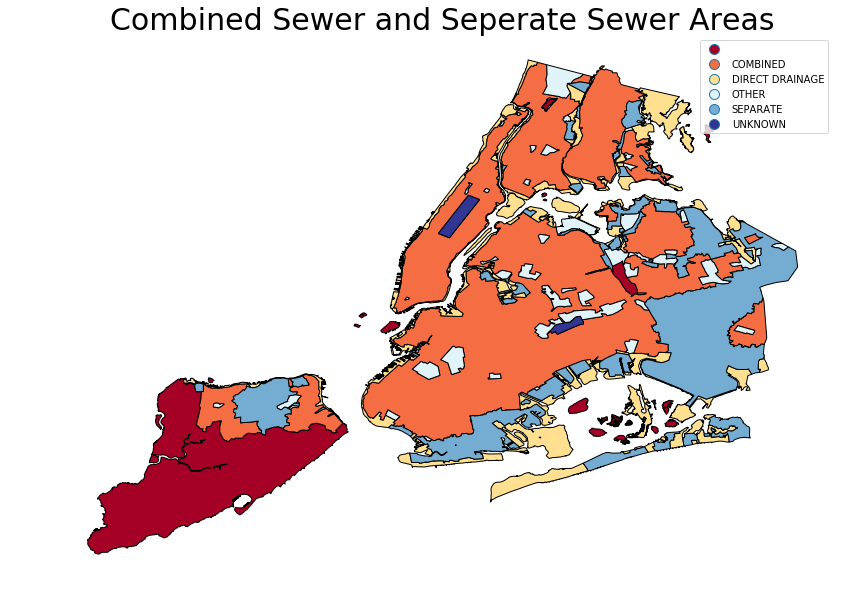

In [5]:
#combined and not combined sewer map
fig, ax = plt.subplots(1,1,figsize=(14,10))

cso_versus_ssewers.plot(legend = True, cmap = 'RdYlBu', categorical = True, edgecolor = 'black',column = 'COMB_OR_SE', ax = ax)

ax.set_axis_off()
ax.set_title('Combined Sewer and Seperate Sewer Areas', fontsize = 30);




## DEP Green Infrastructure shapefile and map

In [6]:
dep_green = GeoDataFrame.from_file("./assets/DEP Green Infrastructure/")

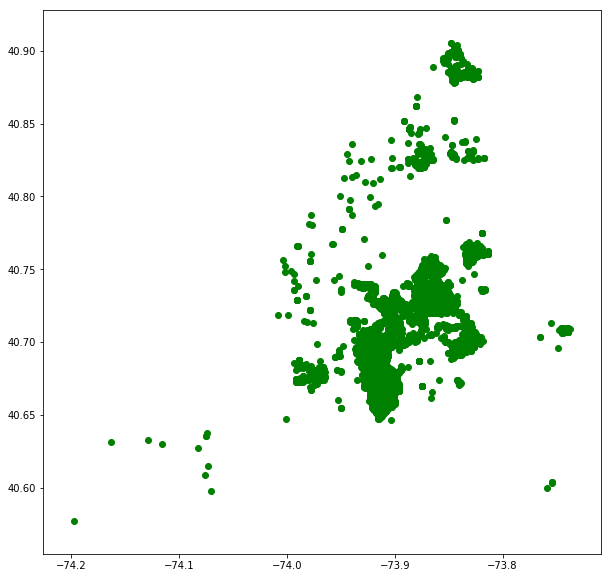

In [7]:
#DEP green infrastructure to minimize storm water entering cso to reduce the number of outflows
fig, ax = plt.subplots(1,1,figsize=(10,10))
dep_green.plot(color = 'green', ax = ax);


## CSO outfall events - UPDATED!  The over 450 CSO outfalls, including the annual volume of CSO discharge and number of events per year, from 2006, 2013, 2014, 2015 and 2016 datasets (pulled from the 2014, 2015 and 2016 NYC DEP SPDES reports).

In [8]:
cso_events = GeoDataFrame.from_file("./assets/dec_cso_2016/")

In [9]:
cso_events['outfall_id'].nunique()

431

In [10]:
cso_events.head()

spdes_id                  facility_n            receiving_ outfall_id  \
0  NY0026191-032  NYCDEP - Hunt's Point WPCP            East River     HP-032   
1  NY0026166-022     NYCDEP - Owls Head WPCP           Gowanus Bay     OH-022   
2  NY0026212-001          NYCDEP - 26th Ward         Hendrix Canal     26-001   
3  NY0026212-002          NYCDEP - 26th Ward  Hendrix Street Canal     26-002   
4  NY0026212-003          NYCDEP - 26th Ward     Fresh Creek Basin     26-003   

   events_06  volume_06  volume_13  events_13  volume_14  events_14  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4         47        494        114          8        255         17   

   events_15  volume_15  events_16  volume_16  discharge_   latitude  \
0          0          0          0          0       Model  40.797506   
1          0          0          0          0       Model  40.660117   
2          0          0          0          0       Model  40.650720   
3          0          0          0          0       Model  40.650658   
4          9         97         20        263  Monitoring  40.649287   

   longtitude                 location                              geometry  
0  -73.886212  (40.797506, -73.886212)          POINT (-73.886212 40.797506)  
1  -74.007959  (40.660117, -74.007959)          POINT (-74.007959 40.660117)  
2  -73.876880    (40.65072, -73.87688)            POINT (-73.87688 40.65072)  
3  -73.876834  (40.650658, -73.876834)          POINT (-73.876834 40.650658)  
4  -73.890436  (40.649287, -73.890436)  POINT (-73.89043599999999 40.649287)

In [11]:
#There is mention of a modeling process for flow in the DEP annual report. Why not monitor the actual flow?
#The answer to this question lies in untangling the bureaucracy that is NYC and is beyond the scope of this project
cso_events['discharge_'].value_counts()

Model         332
Monitoring     87
unknown        12
Name: discharge_, dtype: int64

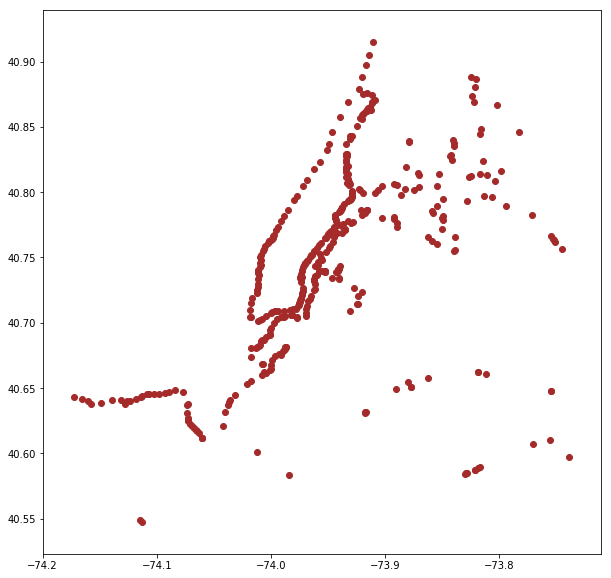

In [12]:
#cso locations
fig, ax = plt.subplots(1,1,figsize=(10,10))
cso_events.plot(color = 'brown', ax = ax);

# Creating a subset for just 2016 for presentation map

In [13]:
cso_events_2016 = cso_events[cso_events['events_16'] > 0][['spdes_id', 'facility_n', 'receiving_', 'outfall_id', 'events_16', 'volume_16', 'discharge_',
       'latitude', 'longtitude', 'location', 'geometry']].copy()

## Wastewater Treatment Plants - The 14 plants that treat our sewage and stormwater.


In [14]:
water_treatment = GeoDataFrame.from_file("./assets/wastewater_treatment_plants/")

In [15]:
water_treatment.shape

(15, 7)

In [16]:
water_treatment.head()

drainage_a dry_weathe                       item_id wpcp population demand  \
0       12947        120                     OWLS HEAD   OH    800,000     64   
1        3200         60                      RED HOOK   RH    200,000     16   
2       15087        110                  CONEY ISLAND   CI    600,000     48   
3       10779         40                 OAKWOOD BEACH   OB    250,000     20   
4           0             SPRING CREEK AUXILIARY PLANT                          

                                 geometry  
0  POINT (-74.03458098999999 40.64181365)  
1        POINT (-73.97848587 40.70227572)  
2         POINT (-73.9335755 40.59022579)  
3        POINT (-74.11880295 40.55088182)  
4        POINT (-73.86380281 40.65880053)

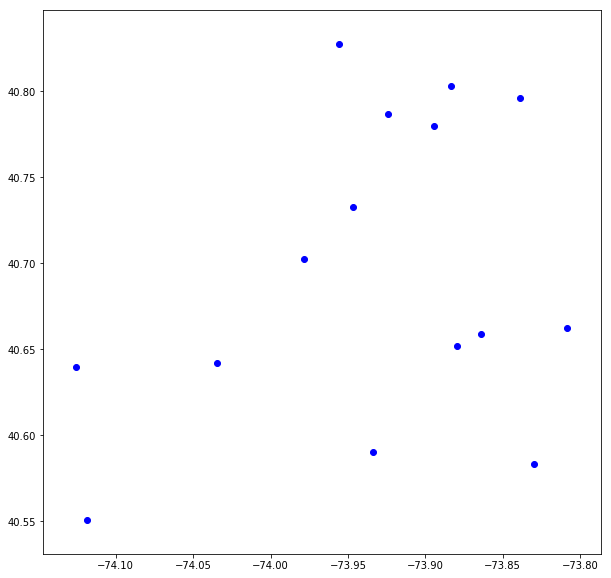

In [17]:
#water treatment plant locations
fig, ax = plt.subplots(1,1,figsize=(10,10))
water_treatment.plot(color = 'blue', ax = ax);

## Sewersheds - The drainage areas for the 14 Wastewater Treatment Plants. Find out which treatment plant treats your household sewage.

In [18]:
sewersheds = GeoDataFrame.from_file("./assets/Sewershed/")

INFO:Fiona:Failed to auto identify EPSG: 7


In [19]:
sewersheds.head()

Pervious  Impervious Sewershed  Population   Housing         Acres  \
0   0.000000    0.000000                   0.0       0.0      0.000000   
1  30.641151   69.358849       26W    294871.0  107893.0   5574.522496   
2  29.636101   70.363899        BB    836144.0  329990.0  16079.430828   
3  36.713526   63.286474        CI    678977.0  270655.0  14368.010570   
4  41.933644   58.066356        HP    730448.0  276302.0  17943.568510   

     Squarefeet    GallonsH2O  \
0  0.000000e+00  0.000000e+00   
1  2.428252e+08  1.513611e+08   
2  7.004172e+08  4.365934e+08   
3  6.258680e+08  3.901244e+08   
4  7.816187e+08  4.872090e+08   

                                            geometry  
0  (POLYGON ((1047580.699751733 252689.6401325307...  
1  (POLYGON ((1016624.204874902 173933.0428111816...  
2  (POLYGON ((994939.7301027044 212343.7746441405...  
3  (POLYGON ((1007348.679746284 157321.9098676963...  
4  (POLYGON ((1015019.860041415 230328.1302236925...

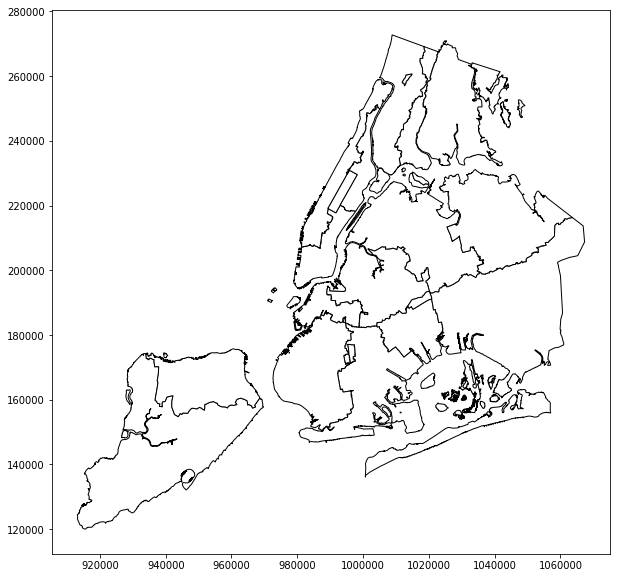

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
#outlining the sewersheds for all of NYC
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax);

## Interceptors -  The large sewer lines in the sewer system that convey large volumes of sewage and stormwater to the wastewater treatment plants. The shapefile also includes force mains. These were drawn referencing pdf documents of NYC’s Long Term Control Plans and a map from NYS Department of Environmental Conservation, and are not comprehensive. 

In [21]:
interceptors = GeoDataFrame.from_file("./assets/interceptors_force_mains/")

In [22]:
interceptors.head()

sewershed         type                     name  \
0        TI  Interceptor  Kissena Corridor Sewers   
1        HP  Interceptor                            
2        BB  Interceptor                            
3        TI  Interceptor  Kissena Corridor Sewers   
4        TI  Interceptor  Kissena Corridor Sewers   

                                            geometry  
0  LINESTRING (-73.78564112311713 40.744892626992...  
1  LINESTRING (-73.87061545708556 40.814726080013...  
2  LINESTRING (-73.94024973294245 40.738452474035...  
3  LINESTRING (-73.75119325266385 40.761970655405...  
4  LINESTRING (-73.74343117508039 40.772994042316...

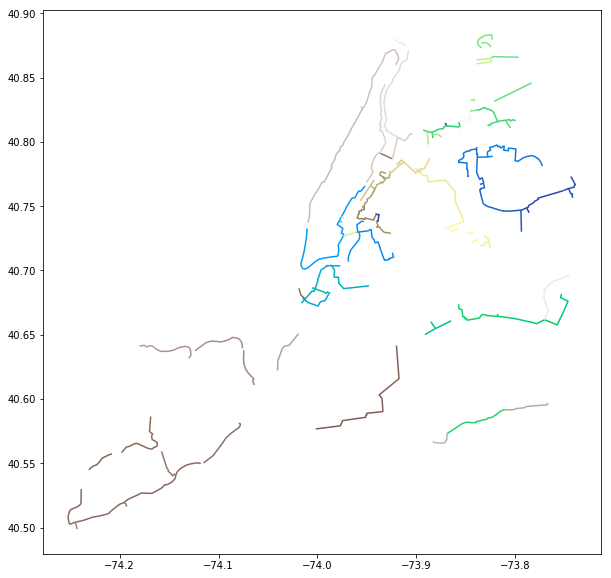

In [23]:
#interceptors that divert water to treatment plants
fig, ax = plt.subplots(1,1,figsize=(10,10))

interceptors.plot(cmap = 'terrain', edgecolor = 'black',alpha = 2, ax = ax);

## Subsewersheds - The drainage area for some of the major interceptors. These were derived using elevation and the interceptor lines.

In [24]:
subsewersheds = GeoDataFrame.from_file("./assets/Subsewersheds/")

INFO:Fiona:Failed to auto identify EPSG: 7


In [25]:
subsewersheds.head()

Sewershed  Subsewersh                                           geometry
0      26 Ward  26 Ward -1  (POLYGON ((1024054.92283382 179436.6890243081,...
1      26 Ward  26 Ward -2  POLYGON ((1011633.204806268 186964.364935316, ...
2  Hunts Point        HP-1  (POLYGON ((1016255.701066551 238889.4778156804...
3  Hunts Point        HP-2  POLYGON ((1038740.784319504 235333.5032043856,...
4  Hunts Point        HP-3  (POLYGON ((1017782.312831995 245196.4158342418...

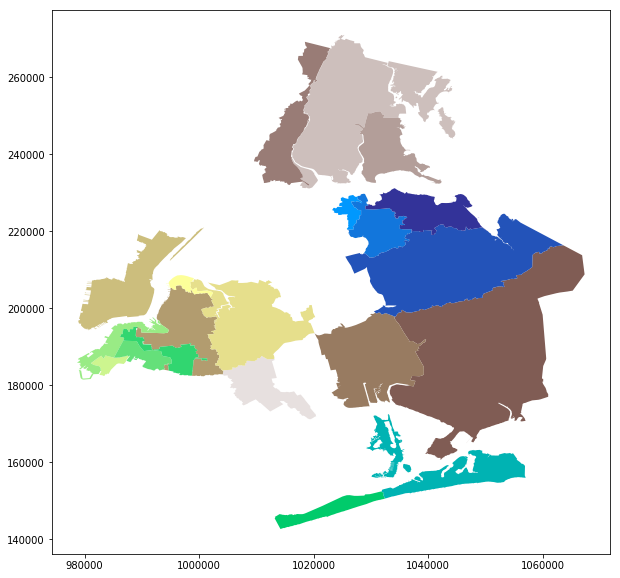

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
subsewersheds.plot(cmap = 'terrain_r', ax = ax);

## Sewer infrastructure - UPDATED! Includes pumping stations, regulators and other mysterious infrastructure (no longer includes outfalls). 

In [27]:
sewer_infrastructure = GeoDataFrame.from_file("./assets/sewer_infrastructure_no_outfalls/")

INFO:Fiona:Failed to auto identify EPSG: 7


In [28]:
sewer_infrastructure.shape

(115, 5)

In [29]:
sewer_infrastructure.head()

FEATURE WPCP ITEM_ID         WATERBODY  \
0  INTERNAL OVERFLOW   HP    IO52       Bronx River   
1  INTERNAL OVERFLOW   HP    IO12       Bronx River   
2  INTERNAL OVERFLOW   HP    IO18  Hutchinson River   
3  INTERNAL OVERFLOW   HP    IO26  Hutchinson River   
4  INTERNAL OVERFLOW   HP    IO28       Bronx River   

                                      geometry  
0  POINT (1019319.948923578 242404.5278654532)  
1  POINT (1019986.427337366 251631.0985168005)  
2  POINT (1029921.359528366 259202.8799638896)  
3                   POINT (1029112.6 261913.8)  
4  POINT (1022414.669900367 249273.1754031885)

In [30]:
#types of structures in Sewer Infrastructure
sewer_infrastructure['FEATURE'].value_counts()

PUMP STATION         92
RELIEF STRUCTURE     14
INTERNAL OVERFLOW     9
Name: FEATURE, dtype: int64

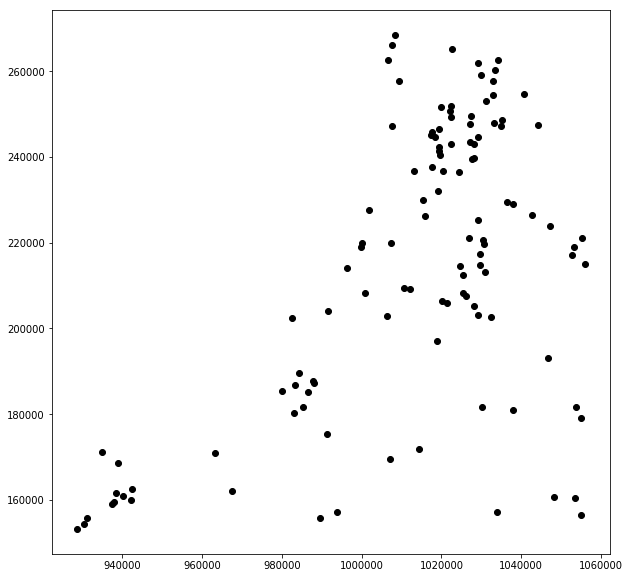

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sewer_infrastructure.plot(color = 'black', ax = ax);

## CSO drainage areas - UPDATED! Perhaps the most valuable GIS layer  - the drainage areas for each of the CSOs! Featured in dontflush.me, and updated using NYC DEP’s green infrastructure map, this helps us further understand the relationship of where we live and where the toilet flushes to in a rainstorm.

These layers have been updated as of November 2016 and may be more current than the online interactive map. If you notice there are any errors in the data, please contact openseweratlasnyc@gmail.com

In [32]:
cso_drainage = GeoDataFrame.from_file("./assets/combinedsewer_drainage_area/")

In [33]:
cso_drainage.head(2)

acreage          area  outfall population  water_use  stormwat_1  \
0     2067  9.005450e+07  26W-003    122,800  9,824,000       56.13   
1      514  2.241071e+07  26W-004     47,600  3,808,000       13.97   

                                            geometry  
0  POLYGON ((-73.90127345027703 40.67981448481336...  
1  POLYGON ((-73.8779550928142 40.65620479356795,...

In [34]:
cso_drainage['outfall'].nunique()

345

In [35]:
#the third letter of the outfall code prefix needs to be removed to be consistent with naming in CSO events
outfall_list = []
for entry in cso_drainage['outfall']:
    outfall_list.append(entry.split('-')[0][0:2]+'-'+entry.split('-')[1])
#putting outfall id with 2 letter prefix code in a new column    
cso_drainage['outfall_id'] = pd.Series(outfall_list)

In [36]:
cso_drainage.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 8 columns):
acreage       345 non-null int64
area          345 non-null float64
outfall       345 non-null object
population    345 non-null object
water_use     345 non-null object
stormwat_1    345 non-null float64
geometry      345 non-null object
outfall_id    345 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 21.6+ KB


In [37]:
#This file has a stormwat_1 amount. This represents the stormwater runoff in a one inch storm in gallons.
#This is an approximation that assumes all surfaces are impervious. It does not account for parks or any pervious surfaces;
 
#stormwat_ is used this number on maps represeting independent of date. 
#Other maps for a given year use  cso_events volume instead.

cso_drainage.head()

acreage          area  outfall population   water_use  stormwat_1  \
0     2067  9.005450e+07  26W-003    122,800   9,824,000       56.13   
1      514  2.241071e+07  26W-004     47,600   3,808,000       13.97   
2     3513  1.530357e+08  26W-005    201,300  16,104,000       95.39   
3       81  3.529111e+06   BB-002        100       8,000        2.20   
4      232  1.012405e+07   BB-003     10,700     856,000        6.31   

                                            geometry outfall_id  
0  POLYGON ((-73.90127345027703 40.67981448481336...     26-003  
1  POLYGON ((-73.8779550928142 40.65620479356795,...     26-004  
2  POLYGON ((-73.85163705437303 40.69755830285387...     26-005  
3  POLYGON ((-73.89534671935471 40.77902496393761...     BB-002  
4  POLYGON ((-73.88904357617233 40.77286781834527...     BB-003

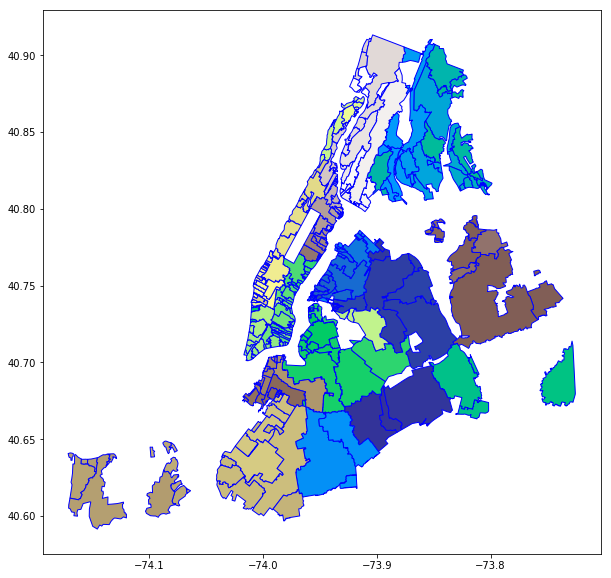

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

#coloring drainage areas for each CSO. Note: Not all of NYC has CSO drainage, there are areas with separate sewers that do not need CSO outfall
cso_drainage.plot(cmap = 'terrain', edgecolor = 'blue',column = 'outfall' ,ax = ax)

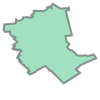

In [39]:
#sample drainage area
cso_drainage['geometry'].iloc[0]

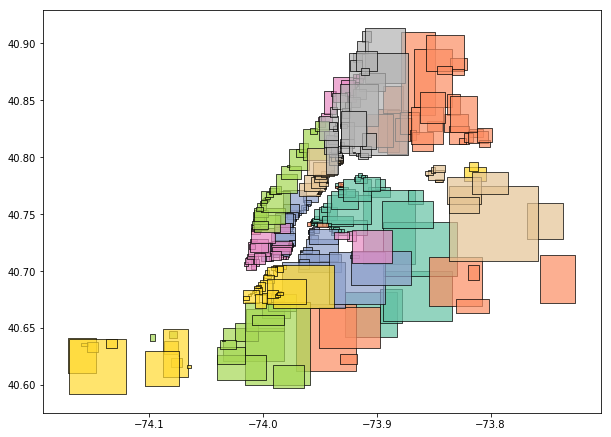

In [40]:
#envelope encases each geometry in a minimal rectangle
cso_drainage.envelope.plot(cmap='Set2', figsize=(10, 10), alpha=0.7, edgecolor='black');

Creating a file of cso location data to merge with data from the cso_drainage file. There are only 431 records when there should be over 450. Some of the cso's have been taken off line. This data is also available on open nyc data. I checked for duplicates based on location there were none. 

In [41]:
cso_events.columns

Index(['spdes_id', 'facility_n', 'receiving_', 'outfall_id', 'events_06',
       'volume_06', 'volume_13', 'events_13', 'volume_14', 'events_14',
       'events_15', 'volume_15', 'events_16', 'volume_16', 'discharge_',
       'latitude', 'longtitude', 'location', 'geometry'],
      dtype='object')

In [42]:
cso_events.head()

spdes_id                  facility_n            receiving_ outfall_id  \
0  NY0026191-032  NYCDEP - Hunt's Point WPCP            East River     HP-032   
1  NY0026166-022     NYCDEP - Owls Head WPCP           Gowanus Bay     OH-022   
2  NY0026212-001          NYCDEP - 26th Ward         Hendrix Canal     26-001   
3  NY0026212-002          NYCDEP - 26th Ward  Hendrix Street Canal     26-002   
4  NY0026212-003          NYCDEP - 26th Ward     Fresh Creek Basin     26-003   

   events_06  volume_06  volume_13  events_13  volume_14  events_14  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4         47        494        114          8        255         17   

   events_15  volume_15  events_16  volume_16  discharge_   latitude  \
0          0          0          0          0       Model  40.797506   
1          0          0          0          0       Model  40.660117   
2          0          0          0          0       Model  40.650720   
3          0          0          0          0       Model  40.650658   
4          9         97         20        263  Monitoring  40.649287   

   longtitude                 location                              geometry  
0  -73.886212  (40.797506, -73.886212)          POINT (-73.886212 40.797506)  
1  -74.007959  (40.660117, -74.007959)          POINT (-74.007959 40.660117)  
2  -73.876880    (40.65072, -73.87688)            POINT (-73.87688 40.65072)  
3  -73.876834  (40.650658, -73.876834)          POINT (-73.876834 40.650658)  
4  -73.890436  (40.649287, -73.890436)  POINT (-73.89043599999999 40.649287)

In [43]:
cso_events['events_16'].value_counts().sort_index().head()

0    74
1    10
2     5
3     5
4     5
Name: events_16, dtype: int64

In [44]:
cso_drainage['stormwat_1'].value_counts().sort_index().head()

0.01    1
0.02    3
0.03    1
0.04    4
0.05    1
Name: stormwat_1, dtype: int64

In [45]:
#This all information from cso_events except events and volume by year.(may not be necessary ). 
#Geometry in this file is a point that represents lat/long
csos = cso_events[['spdes_id','facility_n','outfall_id','receiving_','latitude', 'longtitude', 'location','geometry', ]].copy()

In [46]:
#This removes the area from cso_drainage (not necessary)
#Geometry in this file is a polygon around the cso
cso_drainage = cso_drainage[['outfall_id','acreage','population', 'water_use', 'stormwat_1','geometry', 'outfall']].copy()

In [47]:
cso_drainage.shape

(345, 7)

In [48]:
#This is used to create maps with outflow based on the associated stormwat_1 value(from cso_drainage) 
#and lat/long(from cso_events)
cso_all_info = cso_drainage.merge(csos, how = 'inner', left_on = 'outfall_id', right_on = 'outfall_id')

In [49]:
cso_all_info.columns

Index(['outfall_id', 'acreage', 'population', 'water_use', 'stormwat_1',
       'geometry_x', 'outfall', 'spdes_id', 'facility_n', 'receiving_',
       'latitude', 'longtitude', 'location', 'geometry_y'],
      dtype='object')

In [50]:
cso_all_info.shape

(337, 14)

In [51]:
cso_all_info.head(2)

outfall_id  acreage population  water_use  stormwat_1  \
0     26-003     2067    122,800  9,824,000       56.13   
1     26-004      514     47,600  3,808,000       13.97   

                                          geometry_x  outfall       spdes_id  \
0  POLYGON ((-73.90127345027703 40.67981448481336...  26W-003  NY0026212-003   
1  POLYGON ((-73.8779550928142 40.65620479356795,...  26W-004  NY0026212-004   

           facility_n         receiving_   latitude  longtitude  \
0  NYCDEP - 26th Ward  Fresh Creek Basin  40.649287  -73.890436   
1  NYCDEP - 26th Ward  Fresh Creek Basin  40.654431  -73.879673   

                  location                            geometry_y  
0  (40.649287, -73.890436)  POINT (-73.89043599999999 40.649287)  
1  (40.654431, -73.879673)          POINT (-73.879673 40.654431)

Harbor Water Quality from NYC open data. Large data set starting in 1909 up to 2017. Fecal Coliform testing begins in 1985

In [52]:
water_qual = pd.read_csv('./assets/Harbor_Water_Quality.csv', low_memory = False)

In [53]:
#converting Sample Date to date time.
water_qual['Sample Date'] = pd.to_datetime(water_qual['Sample Date'])

In [54]:
#dates available in data set. The balance of 2017 might be available. Use it to test predictions of time series model?
print(water_qual['Sample Date'].min())
print(water_qual['Sample Date'].max())

1909-03-23 00:00:00
2017-11-21 00:00:00


In [55]:
# subsetting out columns for modeling, location, date, duplicates(quality control), 
#temperature(low temp causes killoff of fecal coliform), fecal results, location
water_fecal = water_qual[['Sampling Location', 'Sample Date','Duplicate Sample','Top Sample Temperature (ºC)',
       'Bottom Sample Temperature (ºC)','Top Fecal Coliform Bacteria (Cells/100mL)',
       'Bottom Fecal Coliform Bacteria (Cells/100mL)','Long', 'Lat', 'Type']].copy()

### Begin Data Cleaning for DEP Harbor Water File and Weatherunderground Rain Data

In [56]:
# fixing rows with data shifted in columns (probably during entry at the DEP). 
#There are entries in Lat with both Long and Lat separated by a comma. 
#And the Long column has a long descriptive string

#creating a column of nans called 'temp'
water_fecal['temp'] = np.nan
lat_list =[]
long_list = []

for entry in water_fecal['Lat']:

    #append split out incorrect entries in 'Lat' with comma and BOTH lat and long, into lat_list and long_list
    if  ',' in str(entry):
        lat_list.append(entry.split(',')[1])
        print(entry.split(',')[1])
        long_list.append(entry.split(',')[0])
        print(entry.split(',')[0])
    #if no comma then put the entry directly into the lat list and a nan in the long list
    else:
        lat_list.append(entry)
        long_list.append(np.nan)
#put the lat_list that now has all the lat values cleaned into 'Lat'
water_fecal['Lat'] = lat_list
#put the recovered long values into the temp column
water_fecal['temp'] = long_list

       

40.679429
-73.988236
40.676141
-73.990053
40.7619
-73.75101


In [57]:
#assigning recovered long values to correct column. 
#If there is a nan in temp use the original value from Long, otherwise take the value from temp.

water_fecal['Long'] = [i if np.isnan(float(j)) else j for i,j in zip(water_fecal['Long'], water_fecal['temp'])] 

In [58]:
#setting temp with .. to nan
water_fecal.loc[water_fecal['Top Sample Temperature (ºC)'] == '..','Top Sample Temperature (ºC)'] = np.nan

In [59]:
water_fecal.loc[water_fecal['Bottom Sample Temperature (ºC)'] == '..','Bottom Sample Temperature (ºC)'] = np.nan

In [60]:
# taking out commas and converting TNTC (Too Many To Count) to 9999999
cols_to_clean = ['Top Fecal Coliform Bacteria (Cells/100mL)',
       'Bottom Fecal Coliform Bacteria (Cells/100mL)']

for cols in cols_to_clean:
    water_fecal[cols] = water_fecal[cols].str.replace(',','')
    water_fecal[cols] = water_fecal[cols].str.replace('TNTC', '9999999')

   
    

In [61]:
#converting strings to numeric
cols_to_convert = ['Top Sample Temperature (ºC)','Bottom Sample Temperature (ºC)',
                   'Top Fecal Coliform Bacteria (Cells/100mL)','Bottom Fecal Coliform Bacteria (Cells/100mL)',
                   'Long', 'Lat']
for cols in cols_to_convert:
    water_fecal[cols] = pd.to_numeric(water_fecal[cols])

In [62]:
water_fecal['Duplicate Sample'].value_counts()

D    2666
Name: Duplicate Sample, dtype: int64

In [63]:
#removing Duplicates Sample that were taken to check the validity of the results
water_fecal = water_fecal.loc[water_fecal['Duplicate Sample'] !='D'].copy()

In [64]:
#not necessary since all top fecal nan rows are dropped
# taking out rows with no data in this subset
# water_fecal.dropna(axis = 0, how = 'all', subset = ['Top Sample Temperature (ºC)','Bottom Sample Temperature (ºC)',
#        'Top Fecal Coliform Bacteria (Cells/100mL)','Bottom Fecal Coliform Bacteria (Cells/100mL)'], inplace = True)

In [65]:
#dropping null Top fecal
#there is too much variation between top and bottom fecal counts to justify setting top to the bottom number when missing

water_fecal.dropna(axis = 0, subset = ['Top Fecal Coliform Bacteria (Cells/100mL)'], inplace = True)

In [66]:
max_top_count = water_fecal[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'] !=9999999]['Top Fecal Coliform Bacteria (Cells/100mL)'].max()

In [67]:
max_top_count

200000.0

In [68]:
#The number of rows with 200,000 as a count for top fecal (before)
water_fecal[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'] == max_top_count]['Top Fecal Coliform Bacteria (Cells/100mL)'].count()

87

In [69]:
#setting Top Fecal to max. 
water_fecal.loc[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'] ==9999999,'Top Fecal Coliform Bacteria (Cells/100mL)']\
= max_top_count


In [70]:
#The number of rows with 200,000 as a count for top fecal (after)
water_fecal[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'] == max_top_count]['Top Fecal Coliform Bacteria (Cells/100mL)'].count()

101

In [71]:
#same for bottom fecal setting TNTC that are 9999999 to the same 200,000
max_bottom_count = water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] !=9999999]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].max()

In [72]:
#The number of rows with 200,000 as a count for top fecal (before)
water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] == max_bottom_count]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].count()

19

In [73]:
#same for bottom fecal setting TNTC that are 9999999 to the max test value for bottom counts
water_fecal.loc[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] ==9999999,'Bottom Fecal Coliform Bacteria (Cells/100mL)']\
= max_bottom_count

In [74]:
#The number of rows with 200,000 as a count for top fecal (after)
water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] == max_bottom_count]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].count()

21

In [75]:
water_fecal.head()

Sampling Location Sample Date Duplicate Sample  Top Sample Temperature (ºC)  \
0                H5  1986-08-11              NaN                        24.00   
1               BR1  2016-07-08              NaN                          NaN   
4                N1  2010-09-07              NaN                        24.44   
7                N1  2007-04-23              NaN                         7.68   
8               AC2  2014-01-09              NaN                          NaN   

   Bottom Sample Temperature (ºC)  Top Fecal Coliform Bacteria (Cells/100mL)  \
0                           24.00                                      794.0   
1                             NaN                                    37000.0   
4                           23.89                                       10.0   
7                            6.90                                      120.0   
8                             NaN                                     2500.0   

   Bottom Fecal Coliform Bacteria (Cells/100mL)       Long        Lat  \
0                                        1219.0 -73.935832  40.787777   
1                                           NaN -73.862714  40.893142   
4                                           NaN -73.916167  40.914500   
7                                           NaN -73.916167  40.914500   
8                                           NaN -73.751008  40.761904   

        Type temp  
0  Permanent  NaN  
1  Permanent  NaN  
4  Permanent  NaN  
7  Permanent  NaN  
8  Permanent  NaN

In [76]:
#This dataframe is for the Map of discharge from cso (brown) and fecal counts for 2016 (red)
water_fecal_2016 = water_fecal[water_fecal['Sample Date'].dt.year ==2016].copy()

In [77]:
#summary of fecal testing for 2016 by site and mean of results
fecal_summary_2016 = water_fecal_2016.groupby('Sampling Location').mean().reset_index()

In [78]:
#examined diff between top bottom fecal results. differences were both positive and negative, nomevidence to support 
#setting top to bottom when missing
# diff_top_bottom = water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)']-water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)']
# diff_top_bottom.dropna(axis=0, inplace = True)
# diff_top_bottom.value_counts().sort_index()

In [79]:
# fig, ax = plt.subplots(1,1,figsize=(20,10))
# diff_top_bottom.hist(bins = 20, ax = ax)


In [80]:
#temp diff also do not support replacing top with bottom temp when missing 
#there can be both positive and negative differences. with most within +/-5 degrees celcius
# diff_temps = water_fecal['Top Sample Temperature (ºC)']-water_fecal['Bottom Sample Temperature (ºC)']

# diff_temps.value_counts().sort_index()

In [81]:
# fig, ax = plt.subplots(1,1,figsize=(20,10))
# diff_temps.hist(bins = 20, ax = ax)

In [82]:
water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] > 1000]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].shape

(1269,)

In [83]:
water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] < 1000]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].shape

(8315,)

# __EDA__

# Creating layered maps of various dataframes, water_fecal, cso_drainage, cso_events, sewersheds, dep_green

In [84]:
#aligning the projection for the shape files in order to layer maps
cso_events = cso_events.to_crs(cso_drainage.crs)
sewersheds = sewersheds.to_crs(cso_drainage.crs)
interceptors = interceptors.to_crs(cso_drainage.crs)


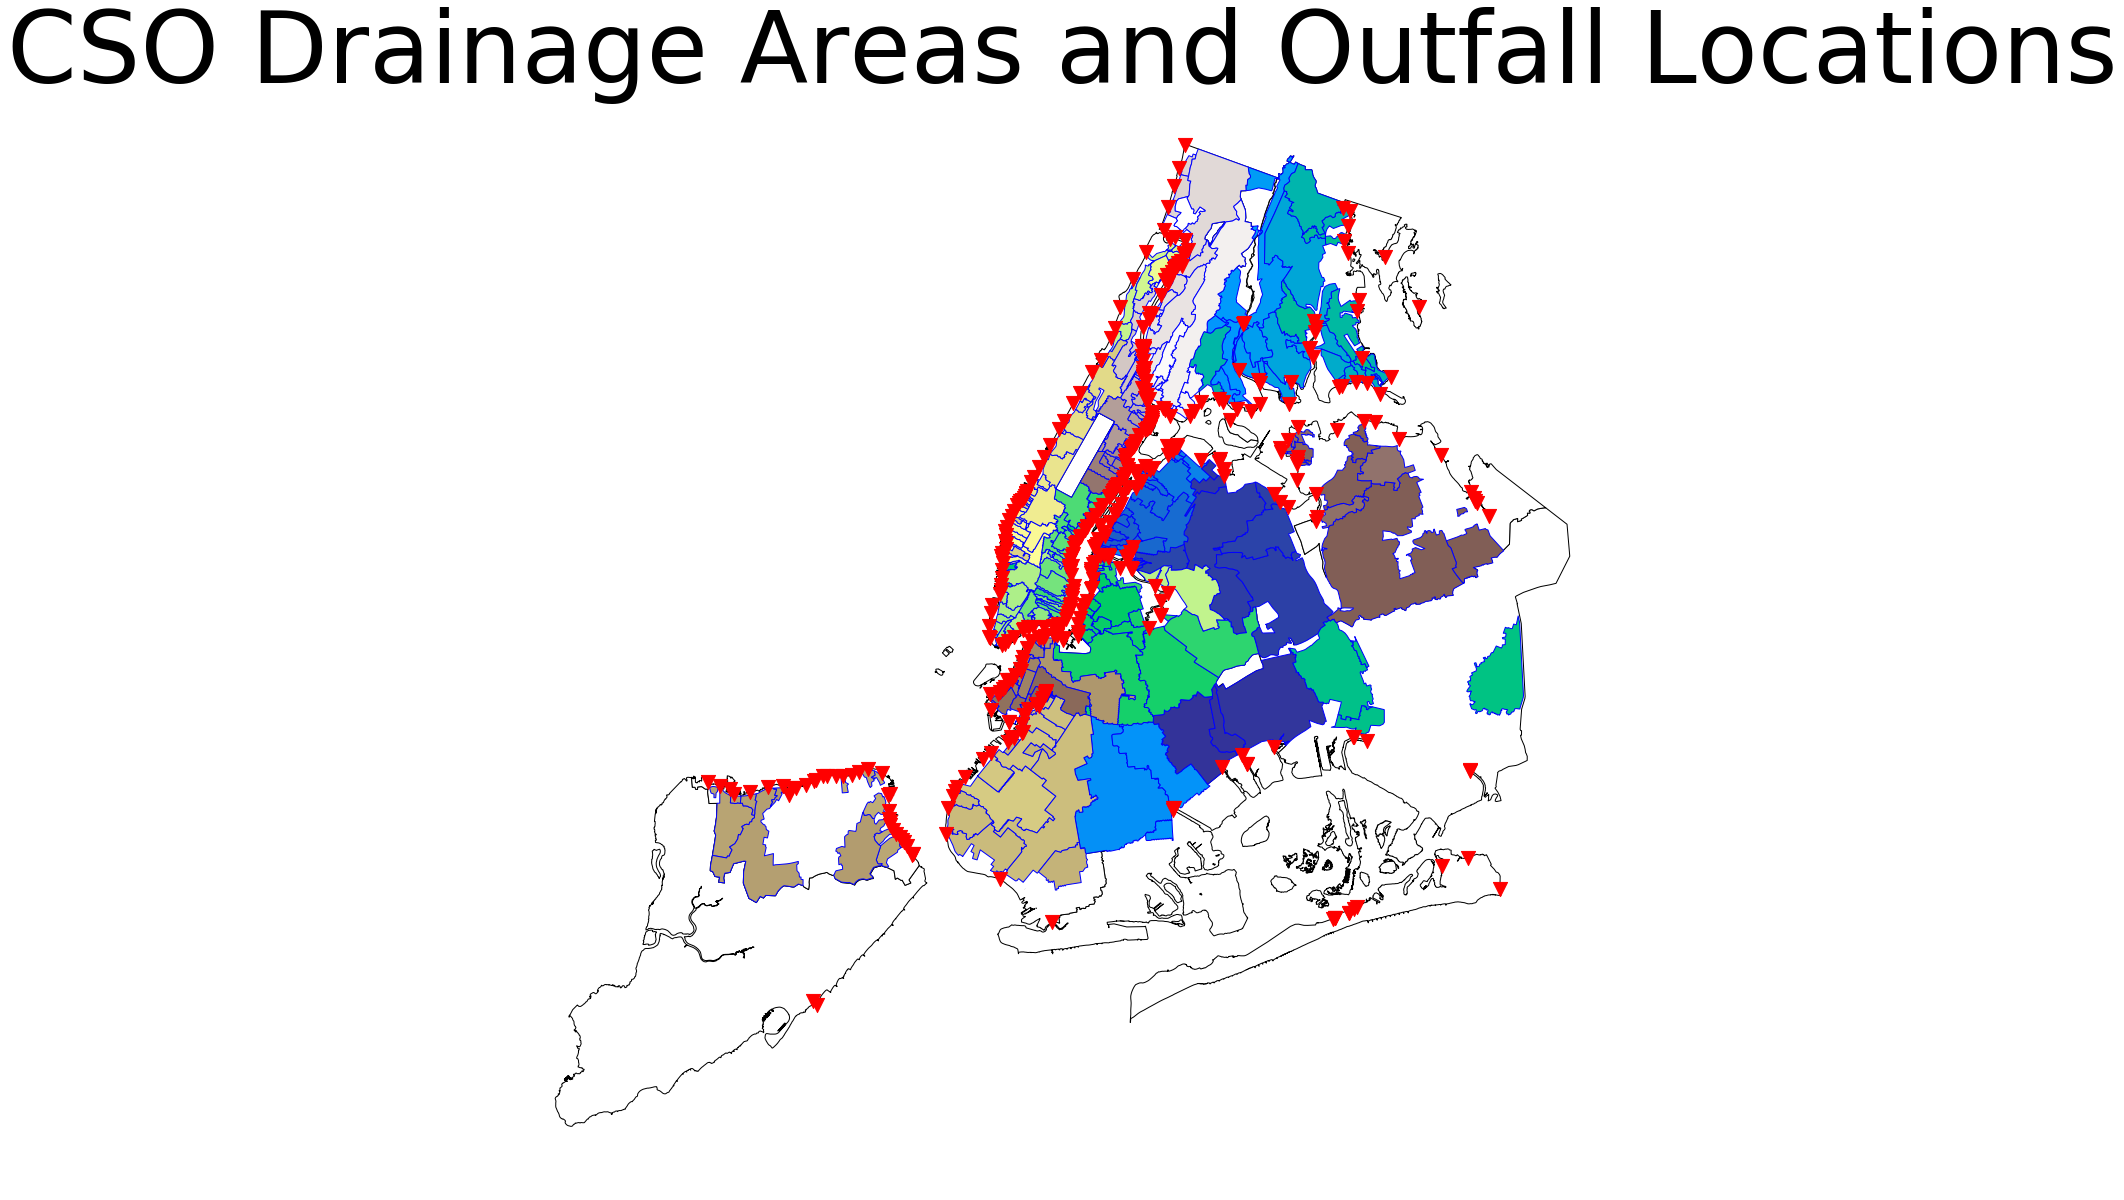

In [85]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
#outlining the sewersheds for all of NYC
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)
#coloring drainage areas for each CSO. Note: Not all of NYC has CSO drainage, there are areas with separate sewers that do not need CSO outfall
cso_drainage.plot(cmap = 'terrain', edgecolor = 'blue',column = 'outfall' ,ax = ax)
#Plotting the location of each CSO with black triangular marker.
cso_events.plot(marker = 'v', markersize = 200,color = 'red', ax = ax)
ax.set_title('CSO Drainage Areas and Outfall Locations', fontsize = 100)

ax.set_axis_off()

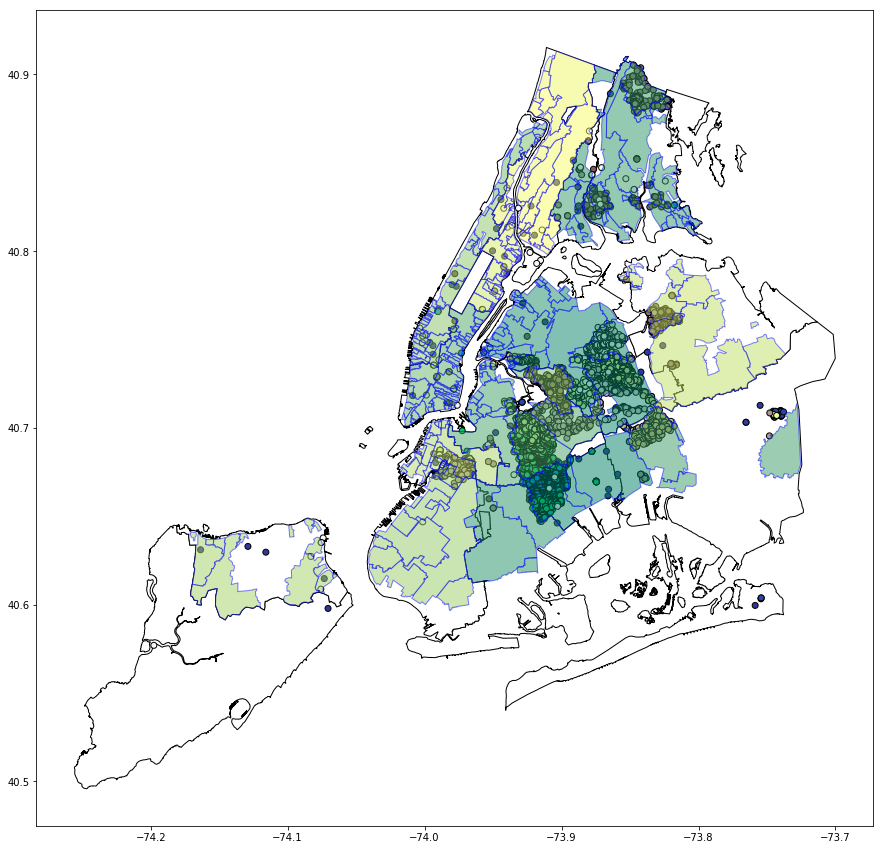

In [86]:
#DEP green infrastructure to minimize storm water entering cso to reduce the number of outflows
fig, ax = plt.subplots(1,1,figsize=(15,15))
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)
dep_green.plot(cmap = 'terrain', edgecolor = 'black',alpha = 2, ax = ax)


#plotting drainage areas
cso_drainage.plot(cmap = 'summer', edgecolor = 'blue',column = 'outfall' ,alpha = 0.5,ax = ax);

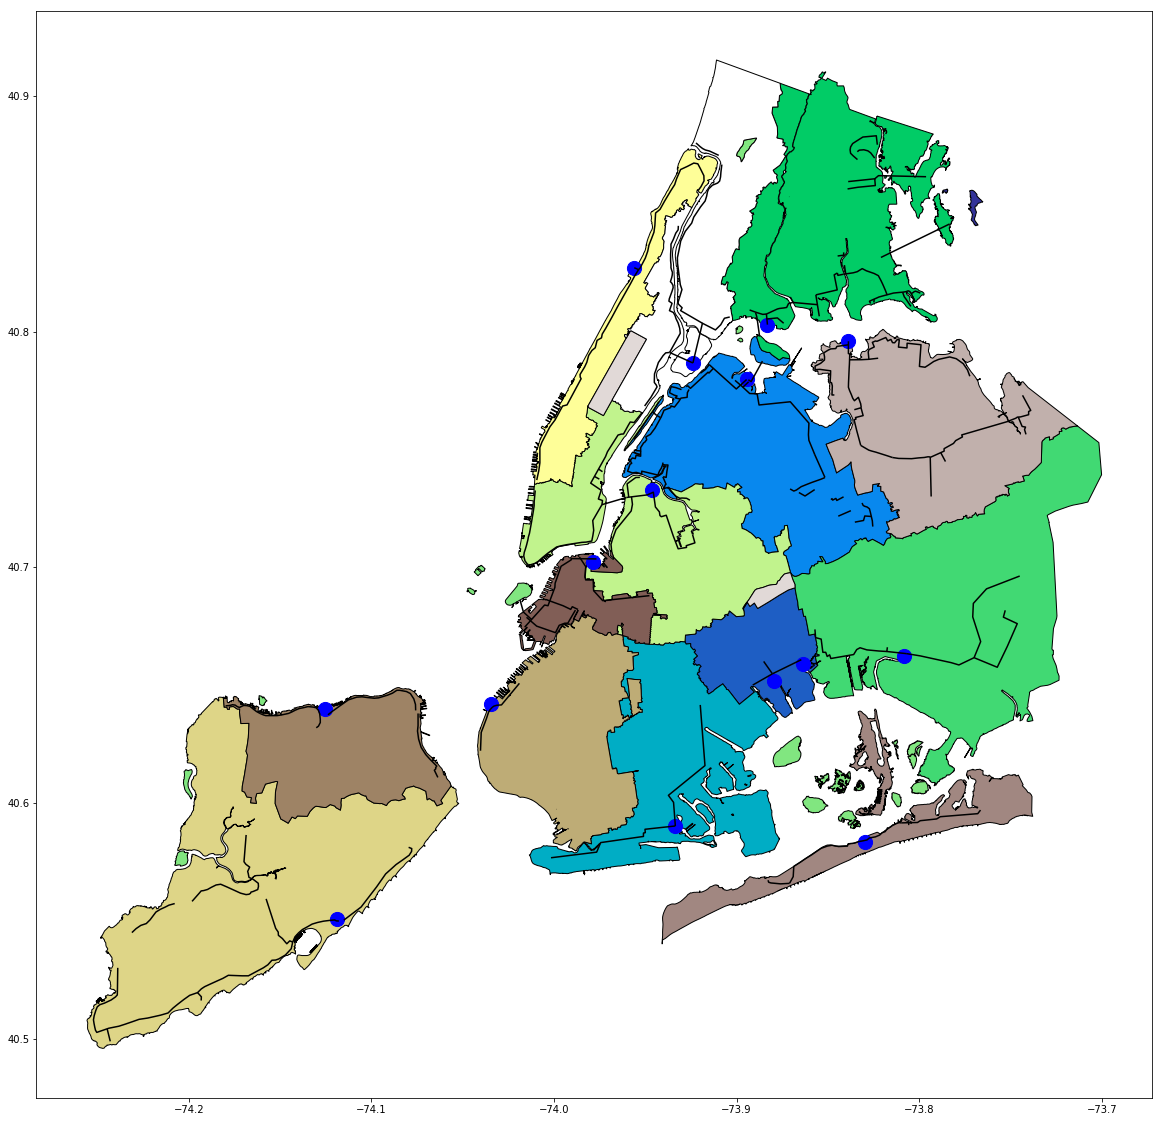

In [87]:
#sewer sheds for the 14 water treatments plants
fig, ax = plt.subplots(1,1,figsize=(20,20))
interceptors.plot(color = 'black', ax = ax, alpha = 1.0)
sewersheds.plot(cmap = 'terrain', edgecolor = 'black', ax = ax)
water_treatment.plot(ax = ax, color = 'blue', marker = 'o', markersize = 200);

In [88]:
#creating an html map layered on nyc of the above
mplleaflet.show(fig=ax.figure, crs=cso_drainage.crs, path='./maps/treatment_plants.html')

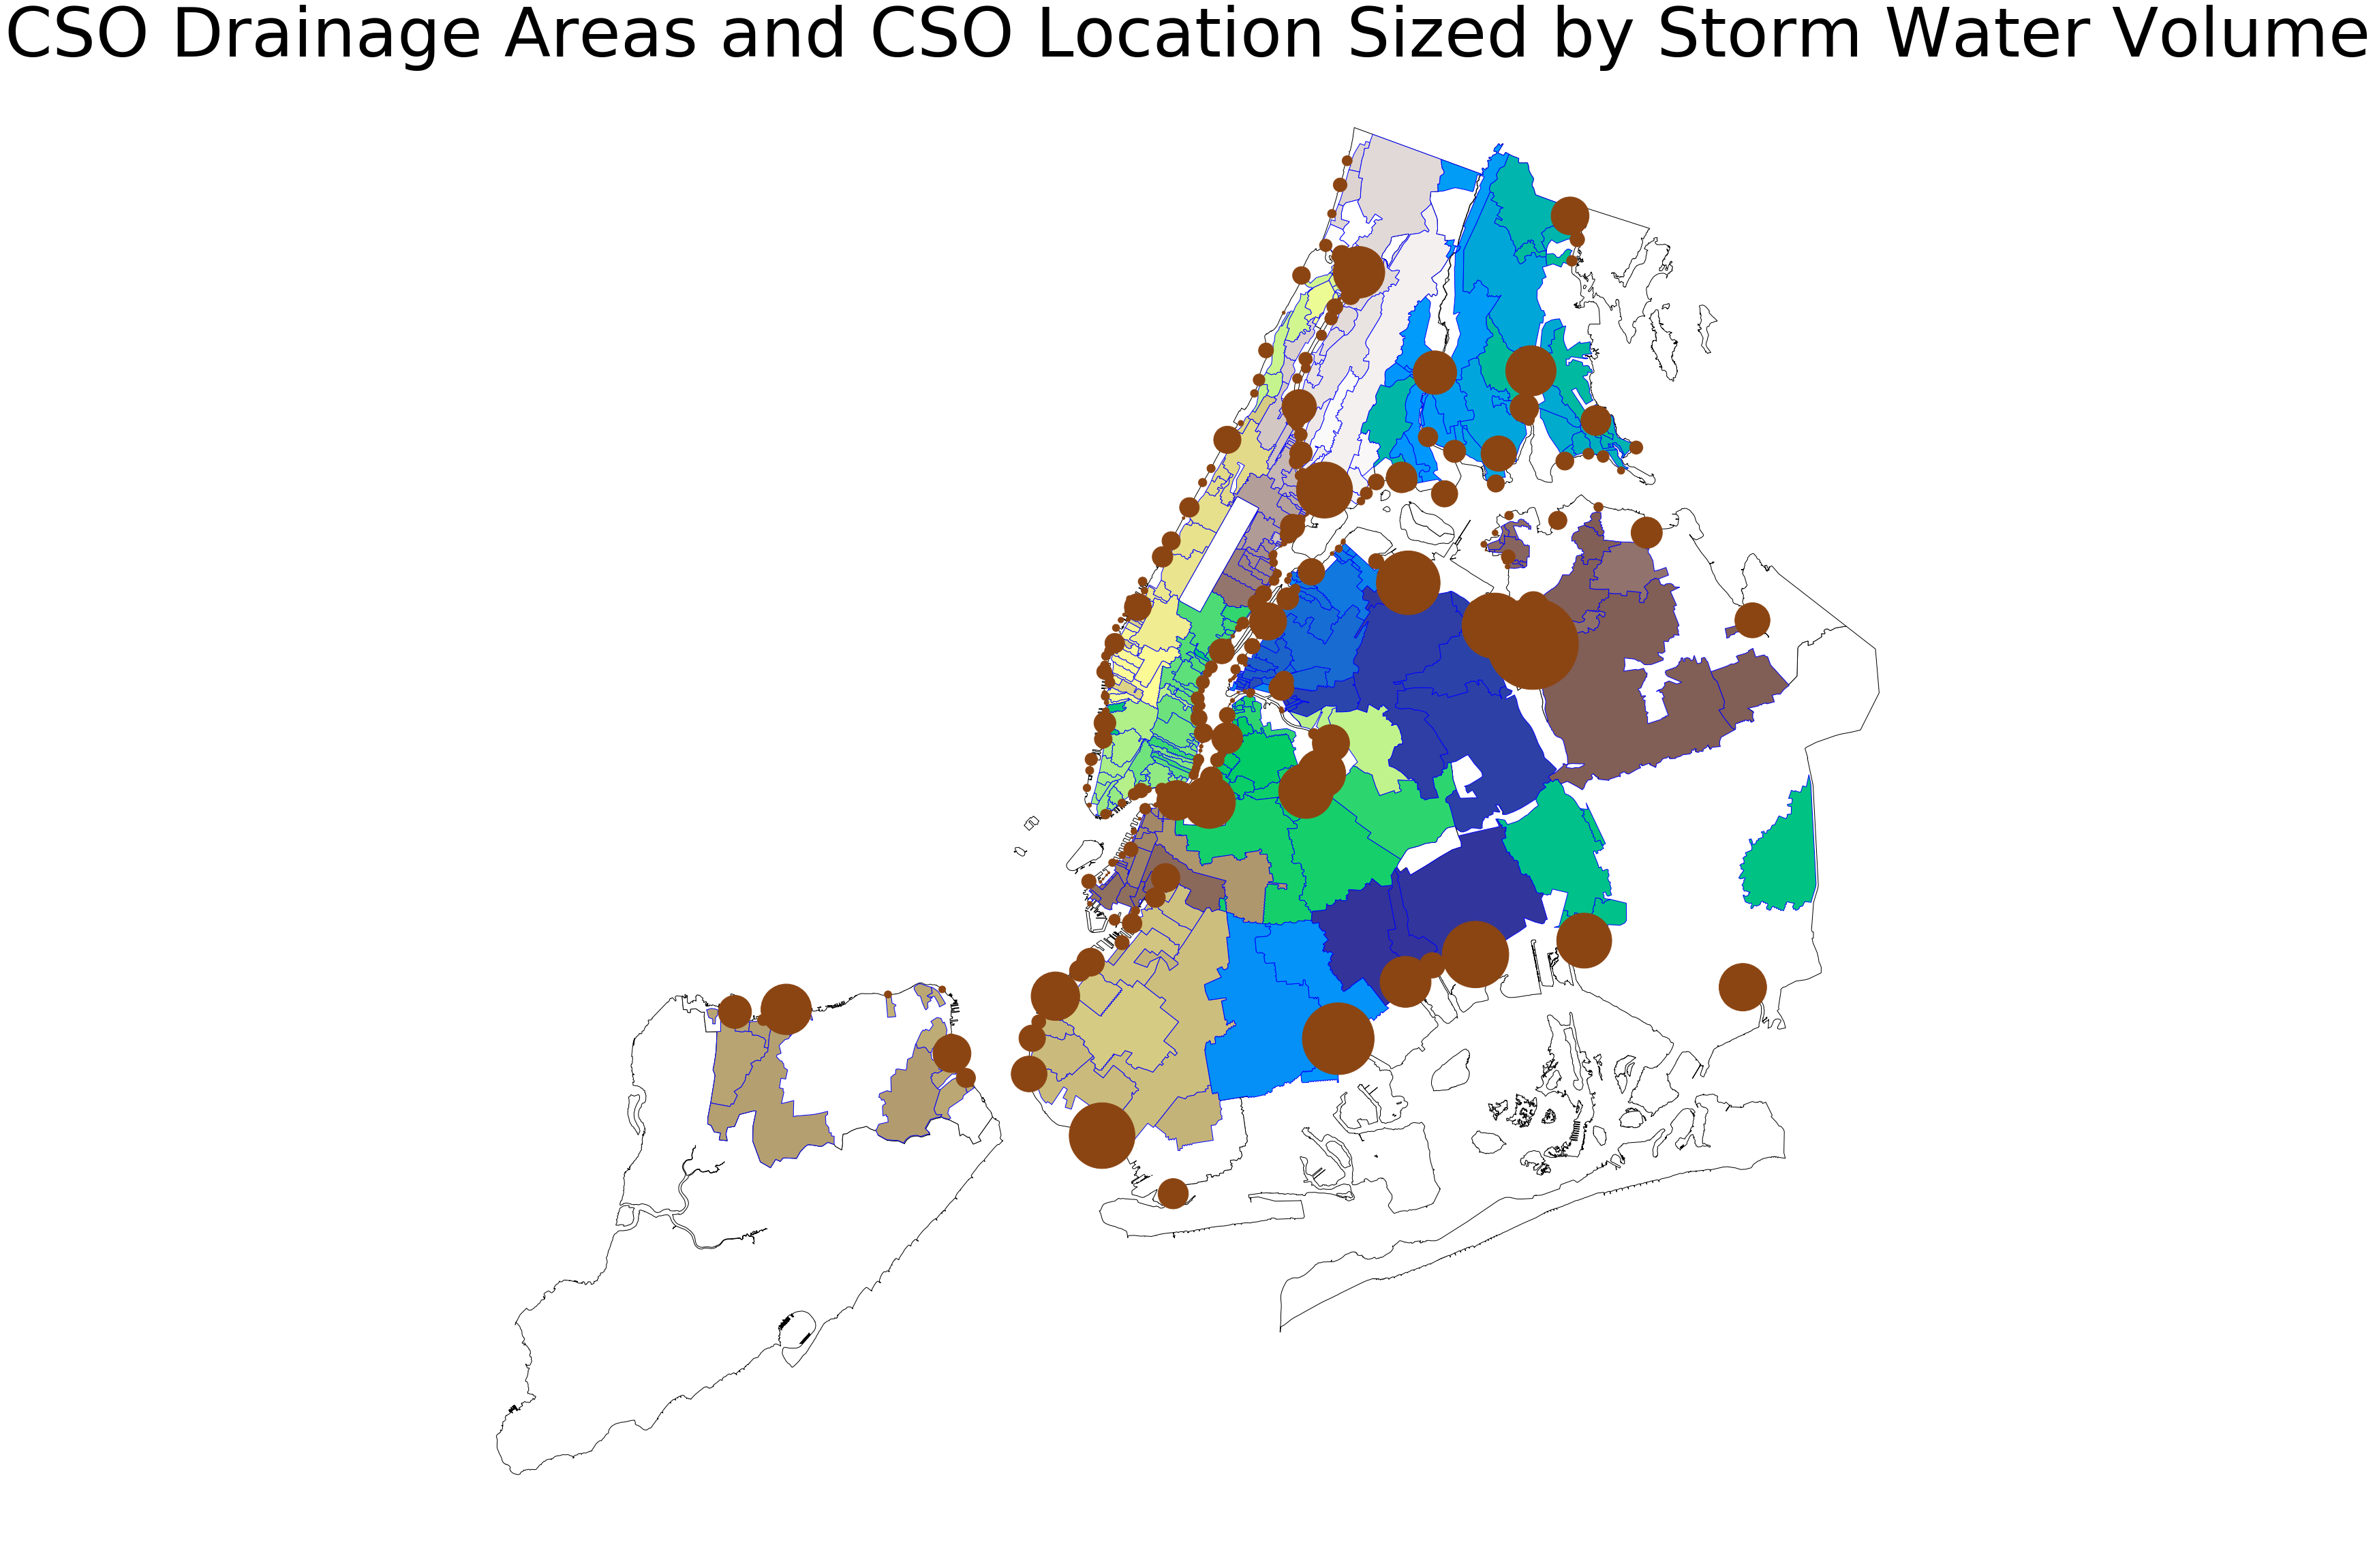

In [89]:
#results for all stormwat_1 volume for all cso's and their drainage areas
fig, ax = plt.subplots(1,1,figsize=(40,40))
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)
cso_drainage.plot(cmap = 'terrain', edgecolor = 'blue',column = 'outfall' ,ax = ax)

pd.DataFrame(cso_all_info).plot(x= 'longtitude', y = 'latitude',marker = 'o', color = 'saddlebrown', s= 100*cso_all_info['stormwat_1'], ax = ax, kind= 'scatter')

ax.set_title('CSO Drainage Areas and CSO Location Sized by Storm Water Volume', fontsize = 100)
#cso_events.plot(markersize = 50,color = 'red', ax = ax)
ax.set_axis_off()

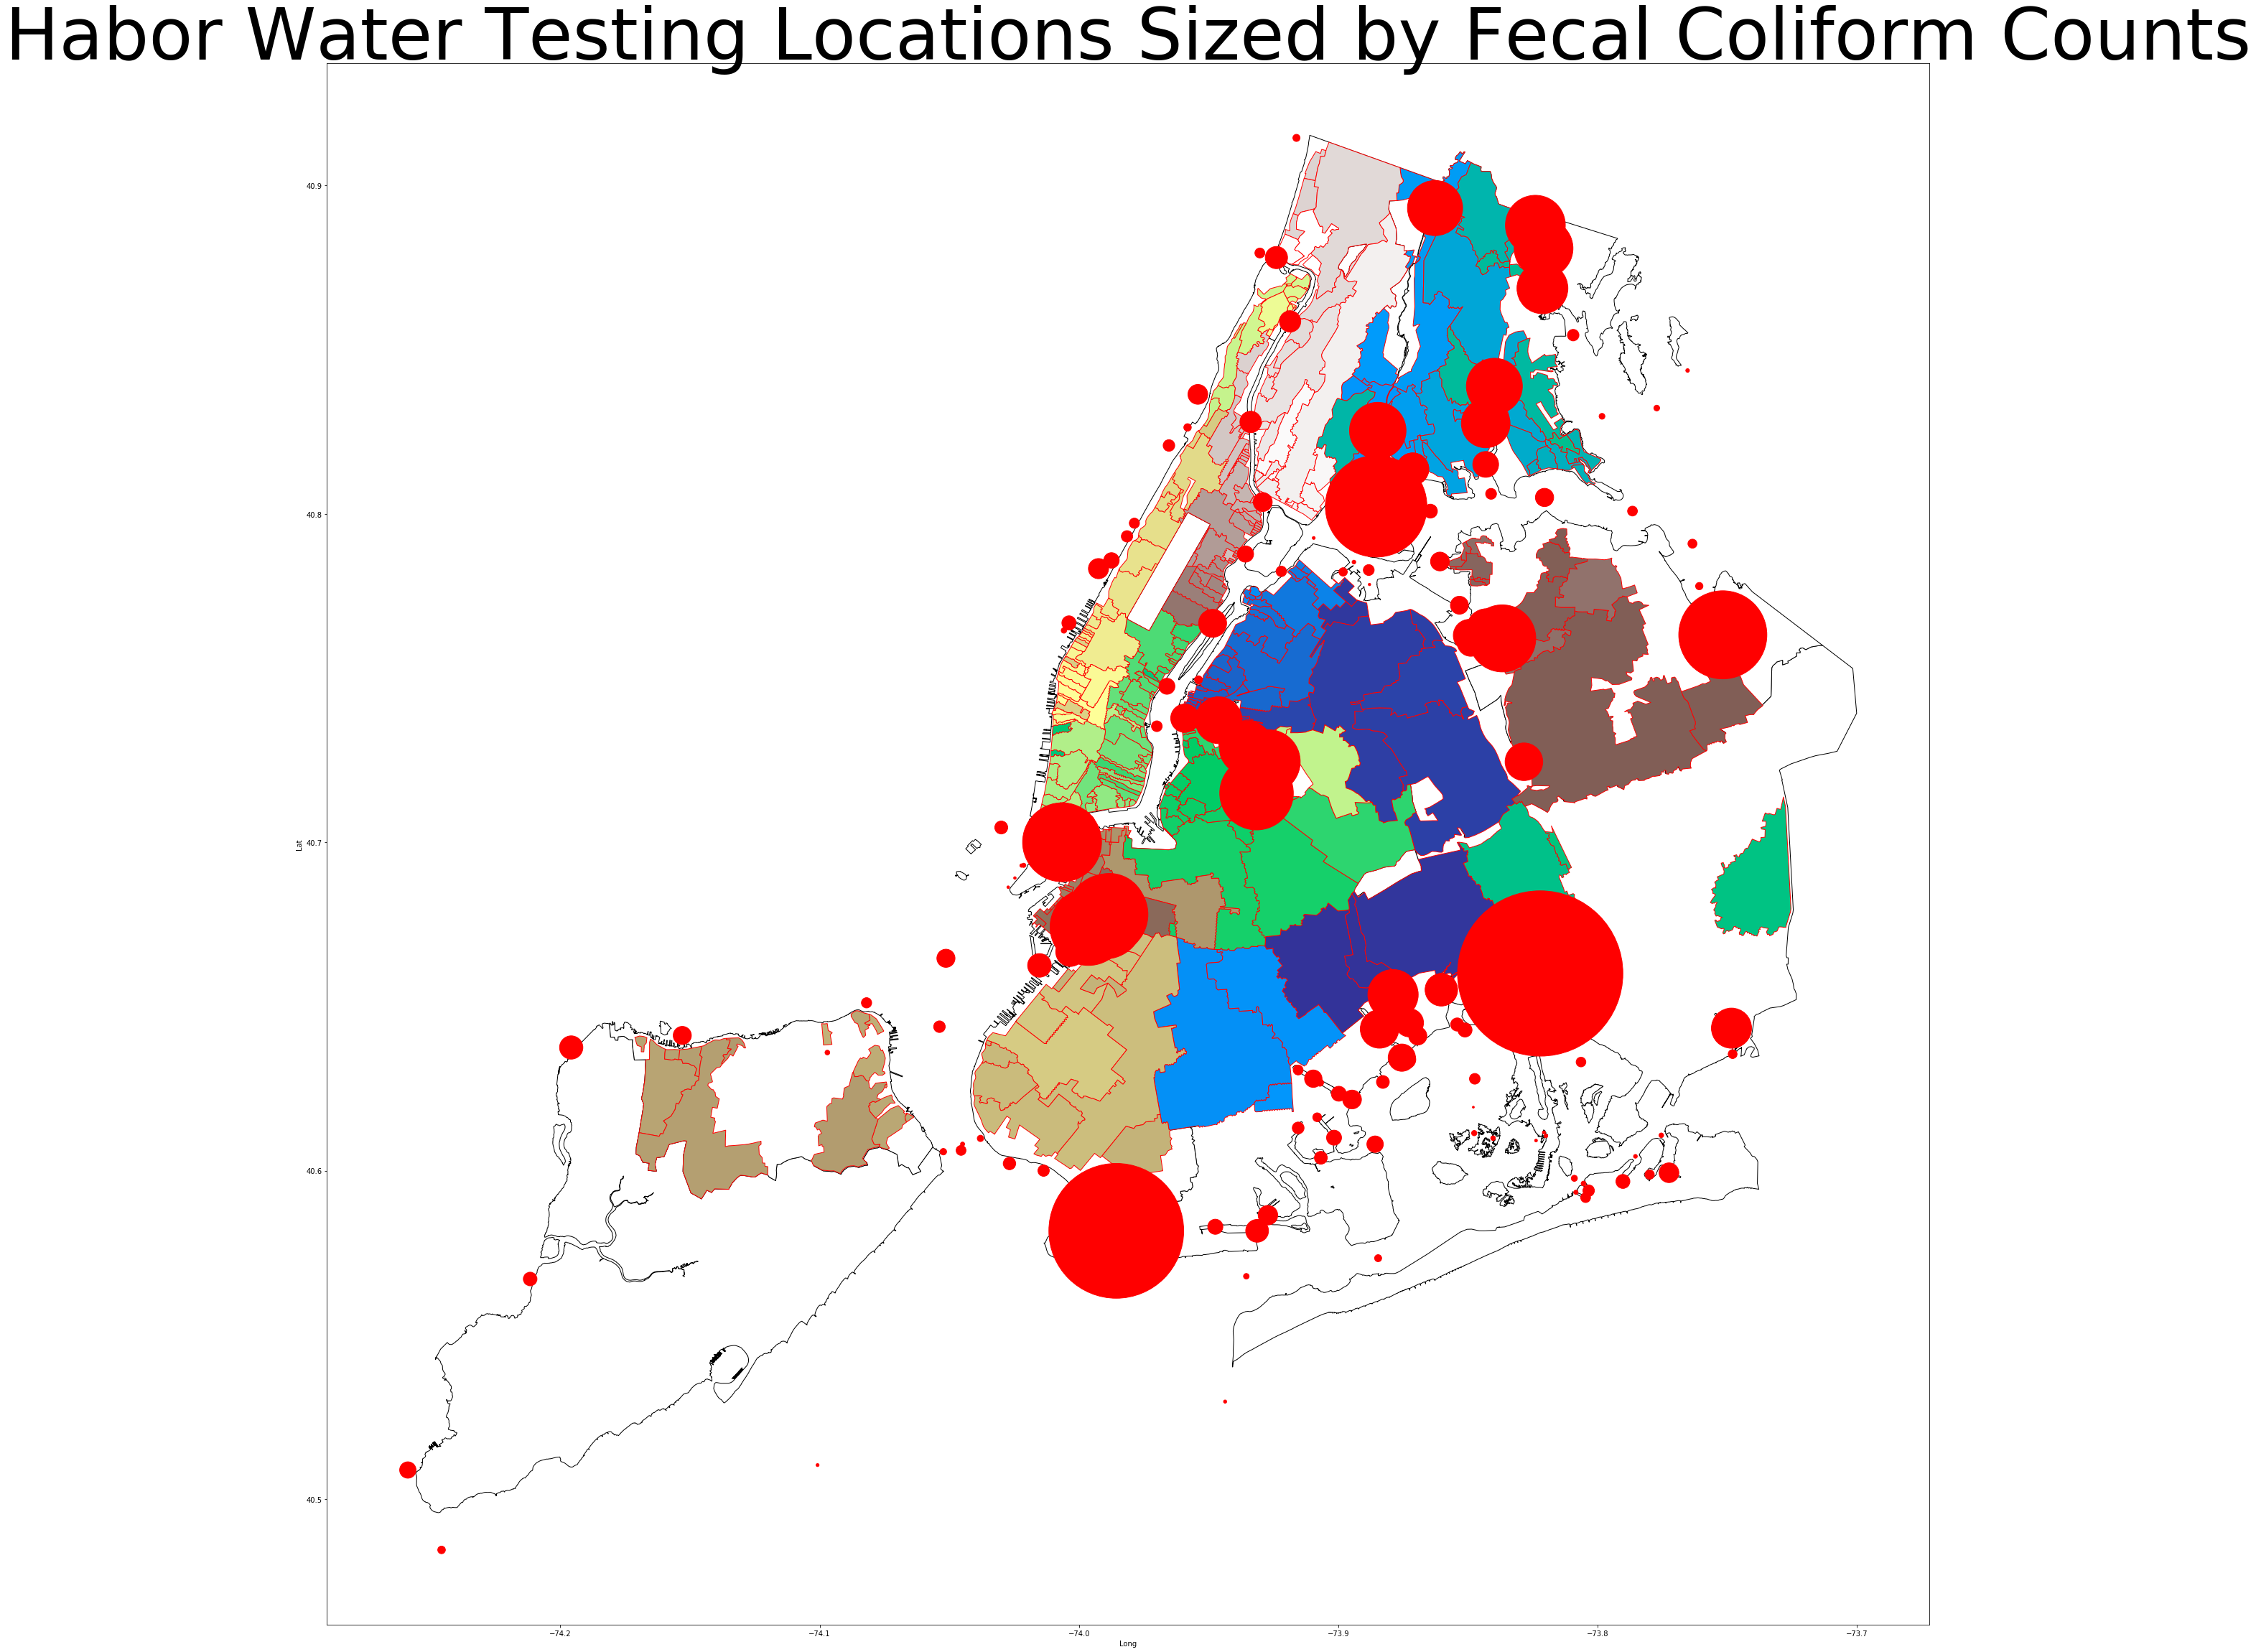

In [90]:
#map of all water test sites sized by mean of fecal coliform results 
fig, ax = plt.subplots(1,1,figsize=(40,40))
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)
cso_drainage.plot(cmap = 'terrain', edgecolor = 'red',column = 'outfall' ,ax = ax)

water_fecal.groupby('Sampling Location').mean().reset_index().plot(x= 'Long', y = 'Lat',marker = 'o', color = 'red', s= water_fecal.groupby('Sampling Location').mean()['Top Fecal Coliform Bacteria (Cells/100mL)'], ax = ax, kind= 'scatter')
ax.set_title('Habor Water Testing Locations Sized by Fecal Coliform Counts', fontsize = 100);

In [91]:
#drainage map and cso stormwat_1 volume and all fecal map 
ax = cso_drainage.plot(cmap = 'terrain', edgecolor = 'red')
pd.DataFrame(cso_all_info).plot(x= 'longtitude', y = 'latitude',marker = 'o', color = 'saddlebrown', s= 100*cso_all_info['stormwat_1'],alpha = 0.5, ax = ax, kind= 'scatter')
water_fecal.groupby('Sampling Location').mean().reset_index().plot(x= 'Long', y = 'Lat',marker = 'o', alpha = 0.5 ,color = 'red', s= water_fecal.groupby('Sampling Location').mean()['Top Fecal Coliform Bacteria (Cells/100mL)'], ax = ax, kind= 'scatter')

#sending above to html map
mplleaflet.show(fig=ax.figure, crs=cso_drainage.crs, path='./maps/drainage.html')

In [92]:
#This puts the test sites on a google map. However the markers cannot be resized according to test levels

test_site_long = water_fecal['Long'].values
test_site_lat = water_fecal['Lat'].values

gmap = gmplot.GoogleMapPlotter(test_site_lat[0],test_site_long[0],18)
gmap.scatter(test_site_lat,test_site_long,'red', edge_width=10, size = 1000, maker = False)
gmap.draw('./maps/test_sites_map.html')



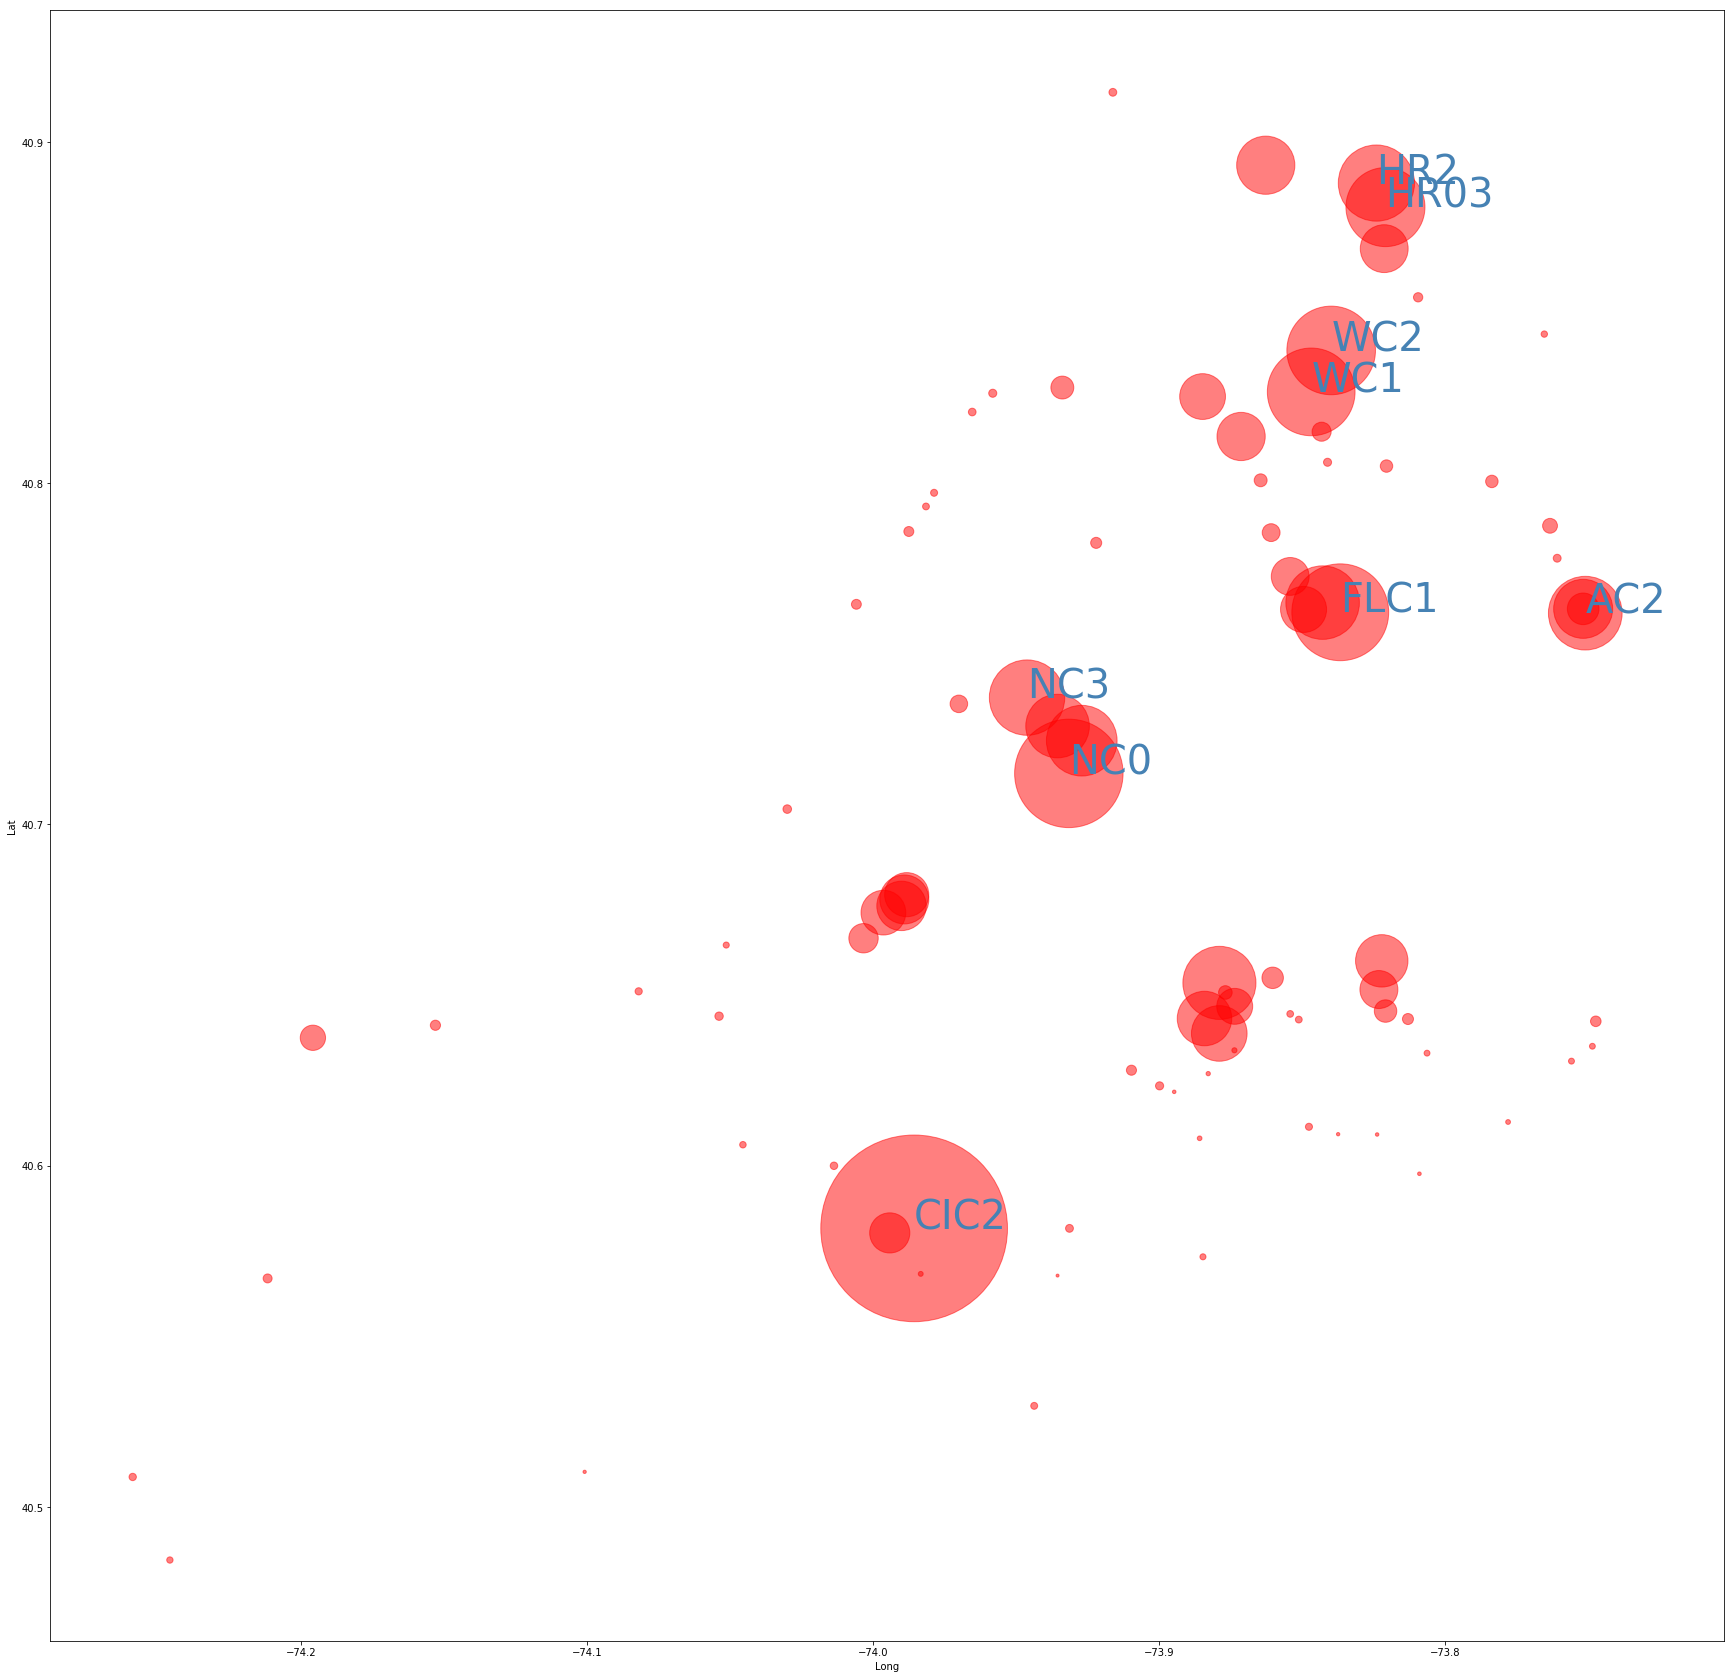

In [93]:
# map of 2016 testing sites with the sites in the top 10% labeled
fig, ax = plt.subplots(1,1,figsize=(30,30))
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = 'o', color = 'red', s= fecal_summary_2016['Top Fecal Coliform Bacteria (Cells/100mL)'], ax = ax, kind= 'scatter')

labels = fecal_summary_2016['Sampling Location'].tolist()


positions = list(zip(fecal_summary_2016['Long'], fecal_summary_2016['Lat']))

#reversing latitude on longitude
#positions = [(j, i) for (i, j) in positions]

for s, p in zip(labels, positions):
     if fecal_summary_2016.loc[fecal_summary_2016['Sampling Location'] ==s]['Top Fecal Coliform Bacteria (Cells/100mL)'].values[0]\
        > fecal_summary_2016['Top Fecal Coliform Bacteria (Cells/100mL)'].quantile([.9]).values[0]:
        
        ax.annotate(s, p, fontsize = 40, color = 'steelblue')



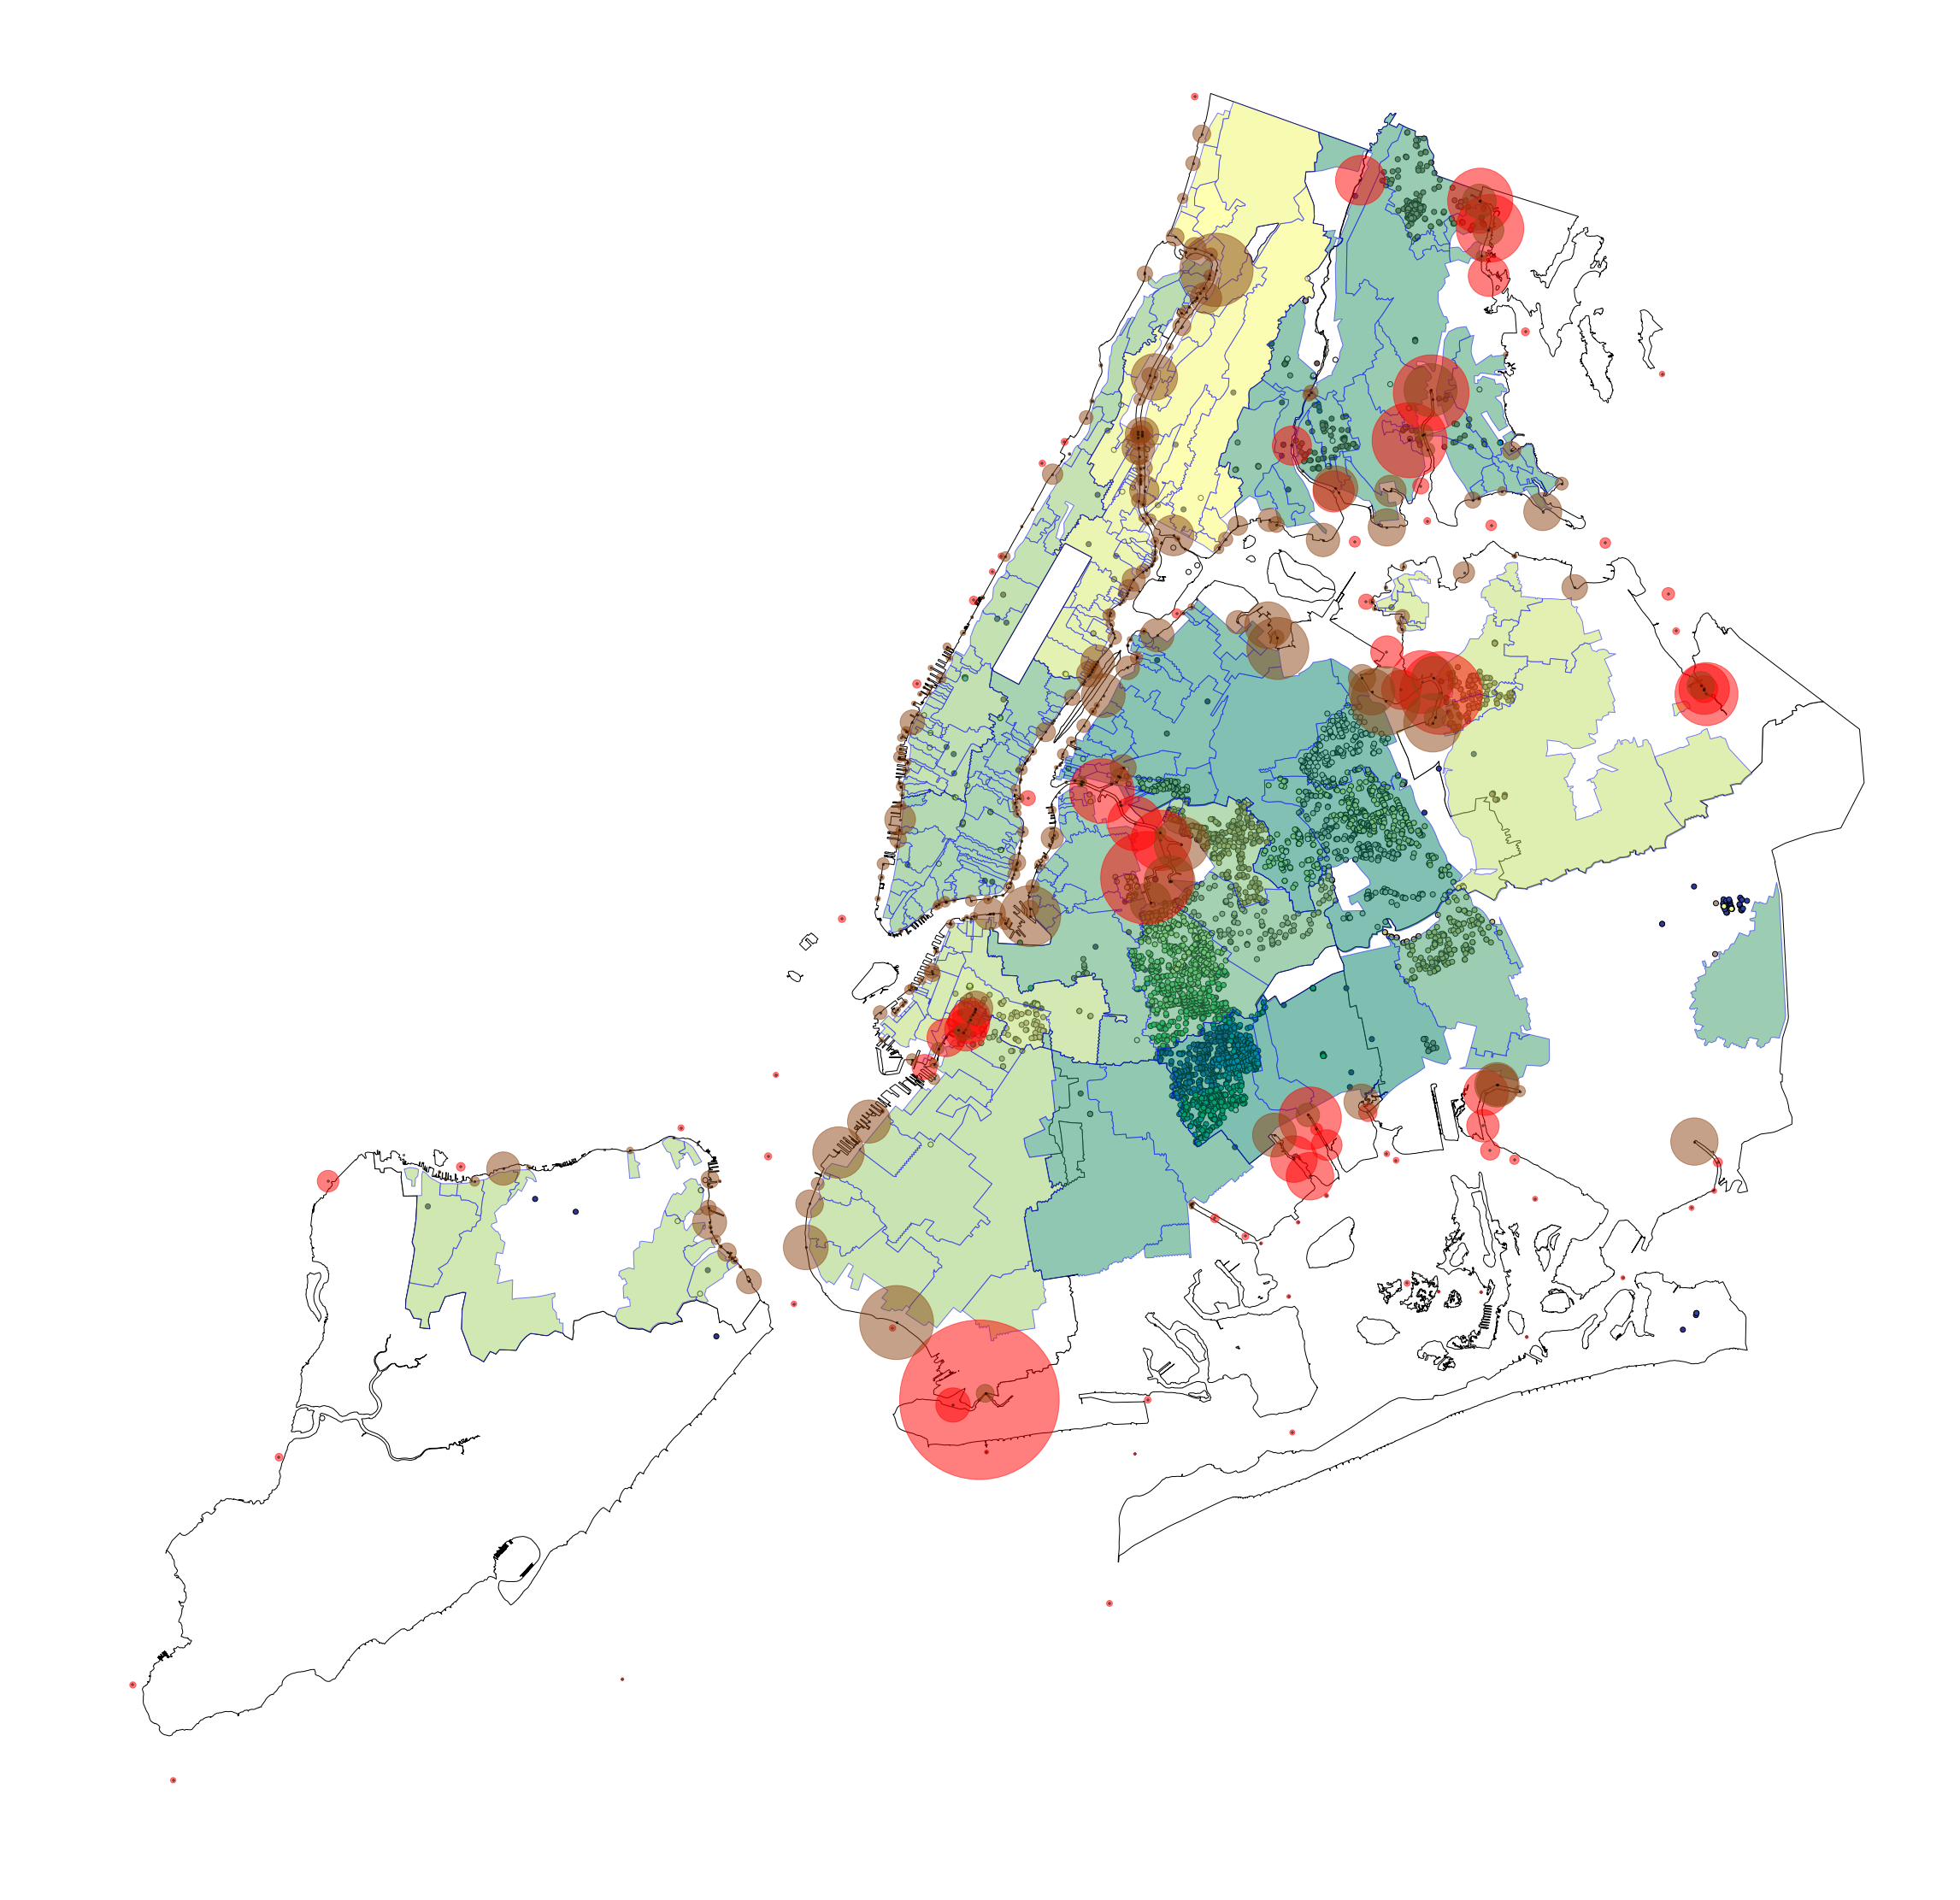

In [94]:
#DEP green infrastructure to minimize storm water entering cso to reduce the number of outflows
fig, ax = plt.subplots(1,1,figsize=(40,40))
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)
dep_green.plot(cmap = 'terrain', edgecolor = 'black',alpha = 2, ax = ax)


#plotting drainage areas
cso_drainage.plot(cmap = 'summer', edgecolor = 'blue',column = 'outfall' ,alpha = 0.5,ax = ax)


#plotting fecal test results
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = 'o', color = 'red', s= fecal_summary_2016['Top Fecal Coliform Bacteria (Cells/100mL)'], ax = ax, kind= 'scatter')
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = '+', color = 'black', ax = ax, kind= 'scatter')


#plotting cso outflows sized by volume for 2016
pd.DataFrame(cso_events_2016).plot(x= 'longtitude', y = 'latitude',marker = 'o', color = 'saddlebrown',s = cso_events_2016['volume_16']*10, alpha = 0.5, ax = ax, kind= 'scatter')
pd.DataFrame(cso_events_2016).plot(x= 'longtitude', y = 'latitude',marker = '.', color = 'black', alpha = 0.5, ax = ax, kind= 'scatter')

ax.set_axis_off()

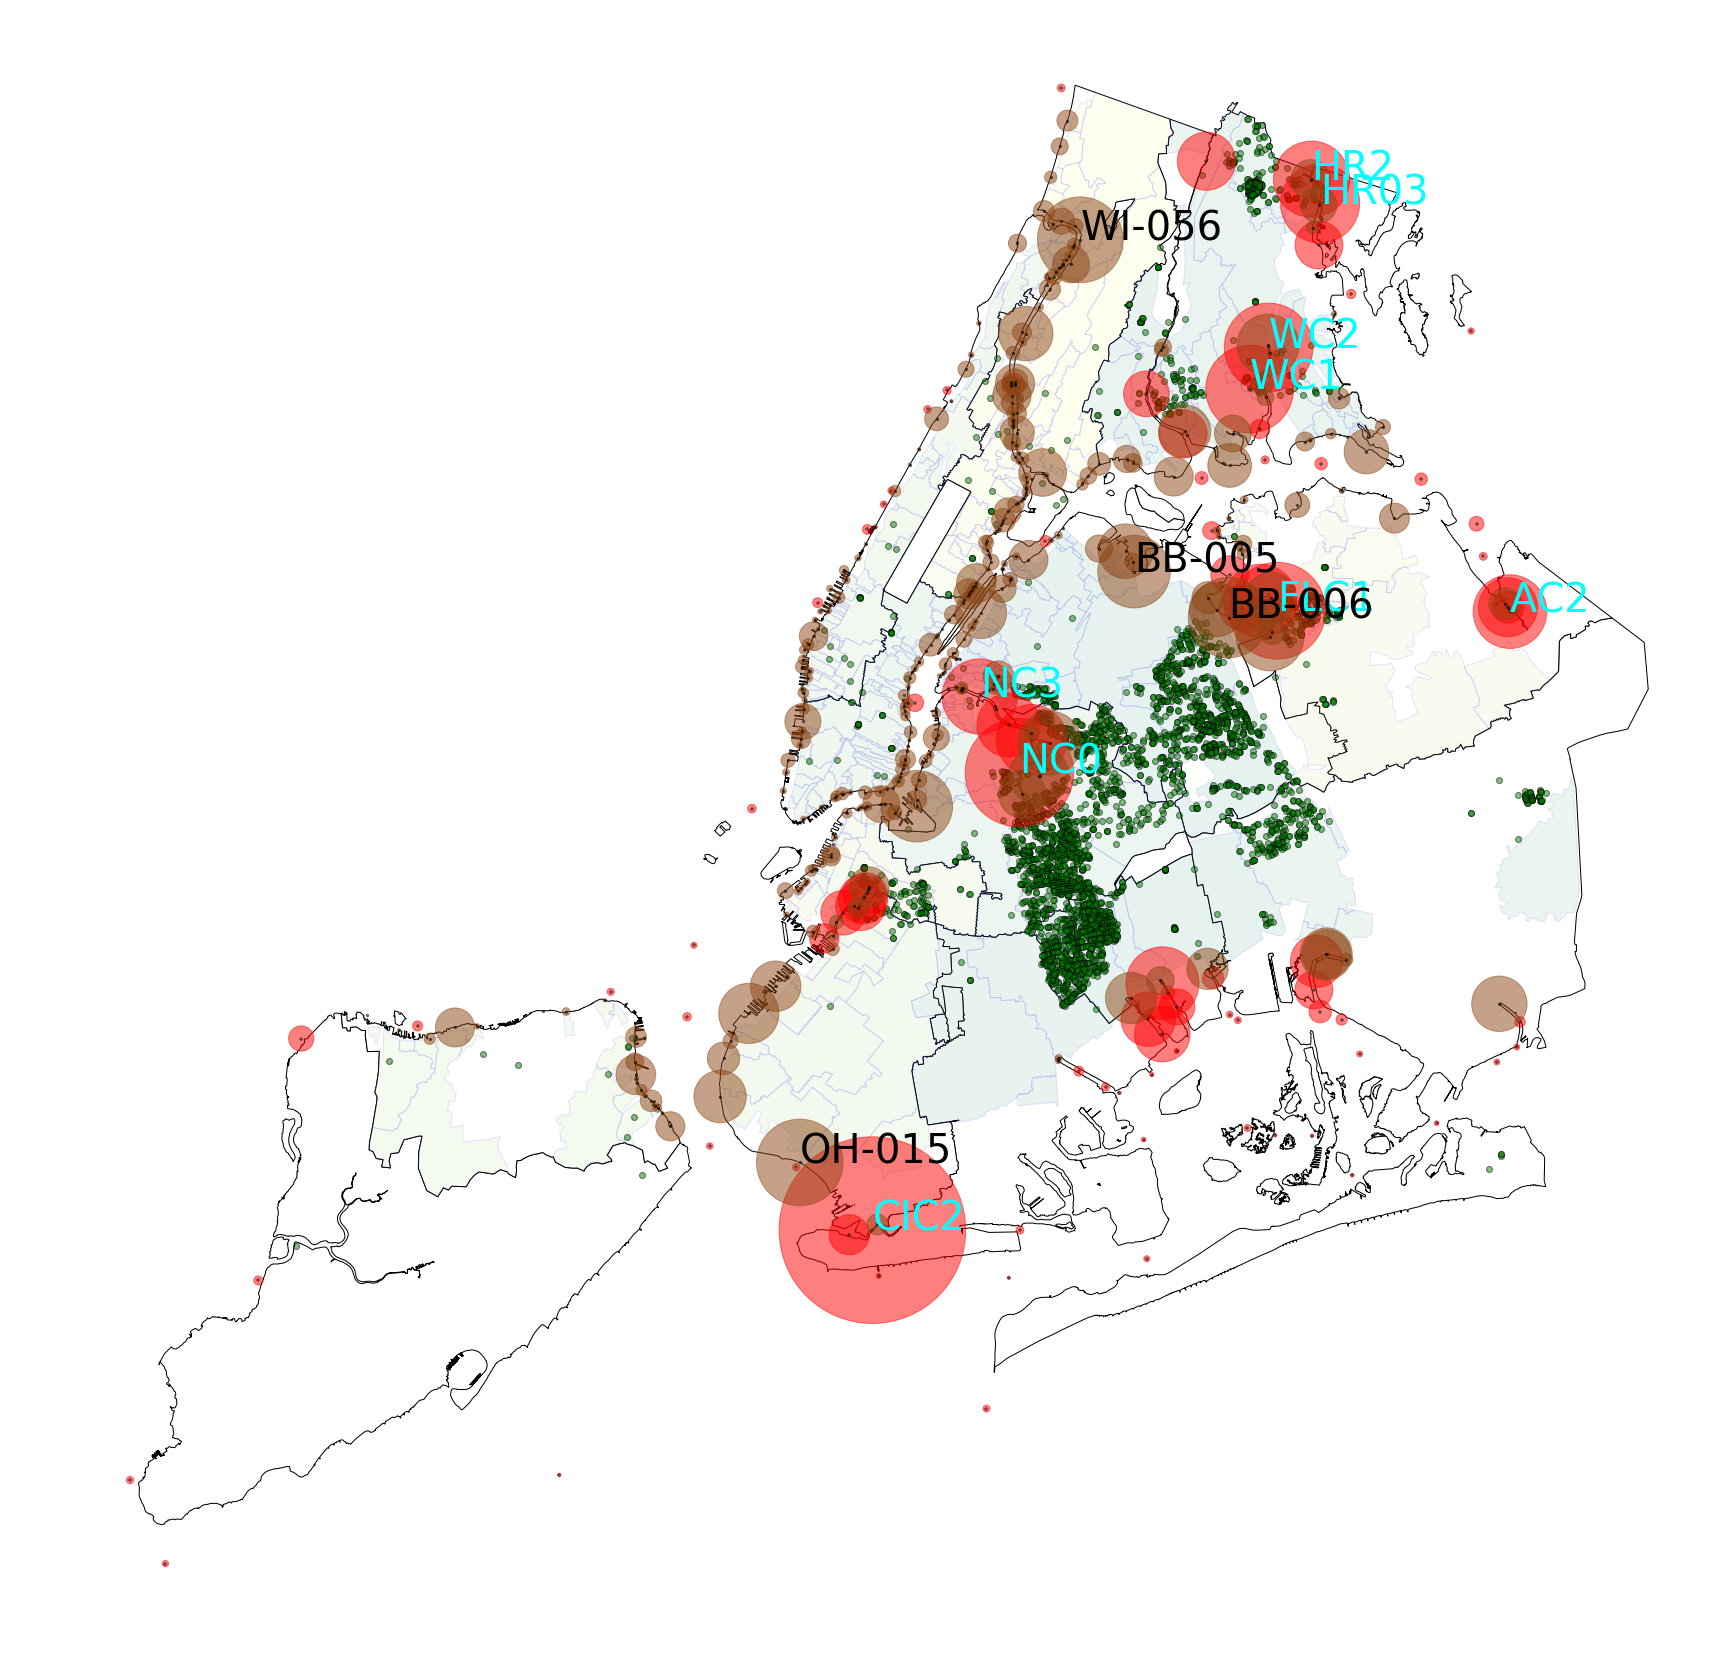

In [95]:
#map of both outflows and fecal results for 2016
fig, ax = plt.subplots(1,1,figsize=(30,30))

#plotting subsewersheds
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)

#plotting drainage areas
cso_drainage.plot(cmap = 'summer', edgecolor = 'blue',column = 'outfall' ,alpha = 0.1,ax = ax)

#plotting green infrastructure (some alpha values will not plot: ValueError: RGBA values should be within 0-1 range)
dep_green.plot(color = 'green', edgecolor = 'black',alpha = .5, ax = ax)

#plotting fecal test results
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = 'o', color = 'red', s= fecal_summary_2016['Top Fecal Coliform Bacteria (Cells/100mL)'], ax = ax, kind= 'scatter')
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = '+', color = 'black', ax = ax, kind= 'scatter')
#labeling top 10%
labels = fecal_summary_2016['Sampling Location'].tolist()

positions = list(zip(fecal_summary_2016['Long'], fecal_summary_2016['Lat']))


for s, p in zip(labels, positions):
     if fecal_summary_2016.loc[fecal_summary_2016['Sampling Location'] ==s]['Top Fecal Coliform Bacteria (Cells/100mL)'].values[0]\
        > fecal_summary_2016['Top Fecal Coliform Bacteria (Cells/100mL)'].quantile([.9]).values[0]:
        
        ax.annotate(s, p, fontsize = 40, color = 'cyan')


#plotting cso outflows sized by volume for 2016
pd.DataFrame(cso_events_2016).plot(x= 'longtitude', y = 'latitude',marker = 'o', color = 'saddlebrown',s = cso_events_2016['volume_16']*10, alpha = 0.5, ax = ax, kind= 'scatter')
pd.DataFrame(cso_events_2016).plot(x= 'longtitude', y = 'latitude',marker = '.', color = 'black', alpha = 0.5, ax = ax, kind= 'scatter')
#labeling the top 1%                 
labels = cso_events_2016['outfall_id'].tolist()
from ast import literal_eval as make_tuple
positions = cso_events_2016['location'].apply(make_tuple)
#ax.set_title('CSO, Bacteria Counts and Green Infrastructure', fontsize = 80)
#reversing latitude on longitude
positions = [(j, i) for (i, j) in positions]

for s, p in zip(labels, positions):
     if cso_events_2016.loc[cso_events_2016['outfall_id']==s]['volume_16'].values[0] > cso_events_2016['volume_16'].quantile([.99]).values[0]:
        ax.annotate(s, p, fontsize = 40, color = 'black')
ax.set_axis_off()

In [96]:
#map of both outflows and fecal results for 2016
fig, ax = plt.subplots(1,1,figsize=(30,30))

#plotting subsewersheds
sewersheds.plot(color = 'white', edgecolor = 'black', ax = ax)
water_treatment.plot(ax = ax, color = 'blue', marker = 'o', markersize = 100)
#plotting drainage areas
cso_drainage.plot(cmap = 'summer', edgecolor = 'blue',column = 'outfall' ,alpha = 0.1,ax = ax)

dep_green.plot(color = 'green', marker = 'o', ax = ax)

#plotting fecal test results
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = 'o', color = 'red', s= fecal_summary_2016['Top Fecal Coliform Bacteria (Cells/100mL)'], ax = ax, kind= 'scatter')
fecal_summary_2016.plot(x= 'Long', y = 'Lat',alpha = 0.5, marker = '+', color = 'black', ax = ax, kind= 'scatter')


#plotting cso outflows sized by volume for 2016
pd.DataFrame(cso_events_2016).plot(x= 'longtitude', y = 'latitude',marker = 'o', color = 'saddlebrown',s = cso_events_2016['volume_16']*10, alpha = 0.5, ax = ax, kind= 'scatter')
pd.DataFrame(cso_events_2016).plot(x= 'longtitude', y = 'latitude',marker = '.', color = 'black', alpha = 0.5, ax = ax, kind= 'scatter')


#creating an html map layered on nyc of the above
mplleaflet.show(fig=ax.figure, crs=cso_drainage.crs, path='./maps/2016.html')


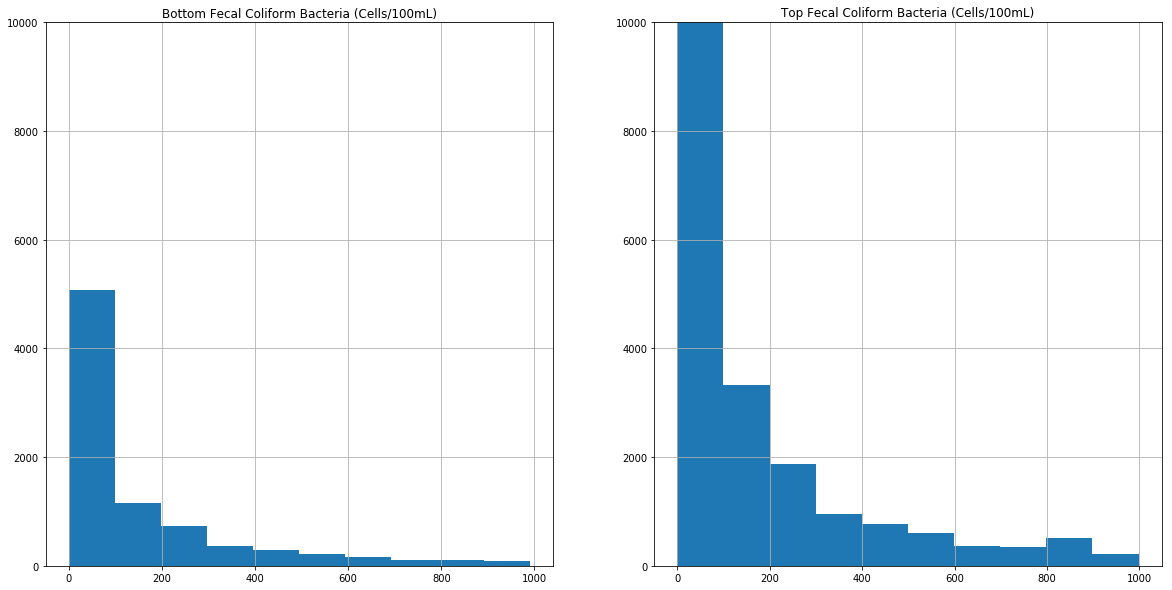

In [97]:
#Looking at fecal counts under 1000

fig, ax = plt.subplots(1,2,figsize=(20,10))

water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] <1000]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[0], bins = 10)
water_fecal[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'] < 1000]['Top Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[1], bins = 10)

ax[0].set_title('Bottom Fecal Coliform Bacteria (Cells/100mL)')
ax[1].set_title('Top Fecal Coliform Bacteria (Cells/100mL)')
ymin = 0
#setting the max height on the y-axis to a count of 10000
ymax = 10000
ax[0].set_ylim([ymin,ymax])
ax[1].set_ylim([ymin,ymax]);

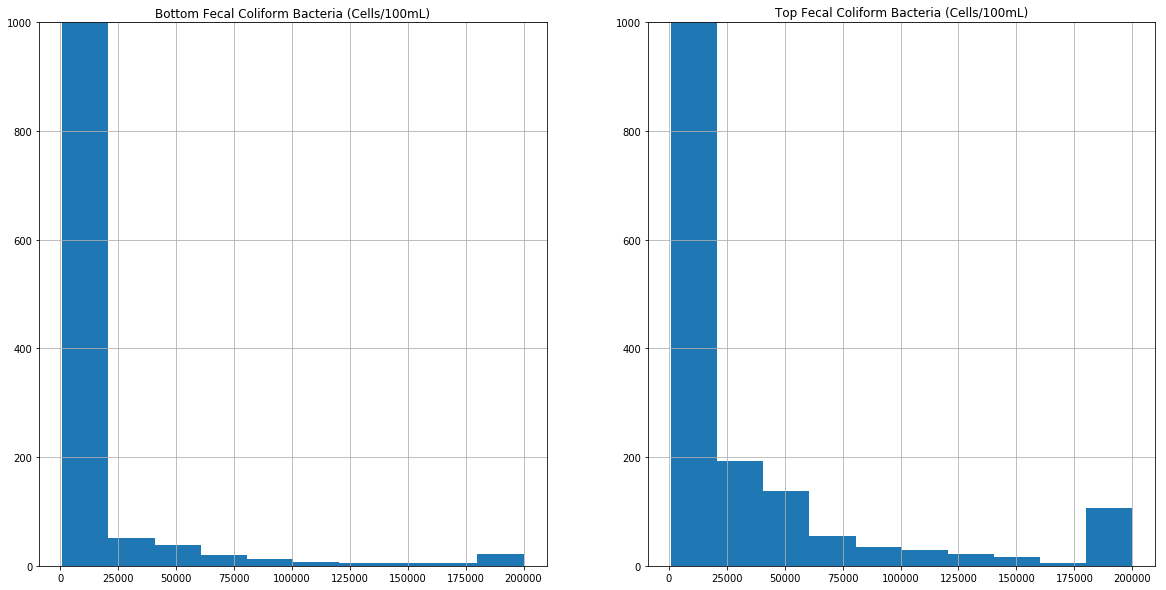

In [98]:
#Looking at fecal counts over 1000
#There are many more Top Fecal counts than Bottom Fecal counts that are 200,000+

fig, ax = plt.subplots(1,2,figsize=(20,10))

water_fecal[water_fecal['Bottom Fecal Coliform Bacteria (Cells/100mL)'] >1000]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[0], bins = 10)
water_fecal[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'] > 1000]['Top Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[1], bins = 10)
#water_fecal[water_fecal['Top Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[1], bins = 10)
ax[0].set_title('Bottom Fecal Coliform Bacteria (Cells/100mL)')
ax[1].set_title('Top Fecal Coliform Bacteria (Cells/100mL)')
ymin = 0
#setting the max height on the y-axis to a count of 100
ymax = 1000
ax[0].set_ylim([ymin,ymax])
ax[1].set_ylim([ymin,ymax]);

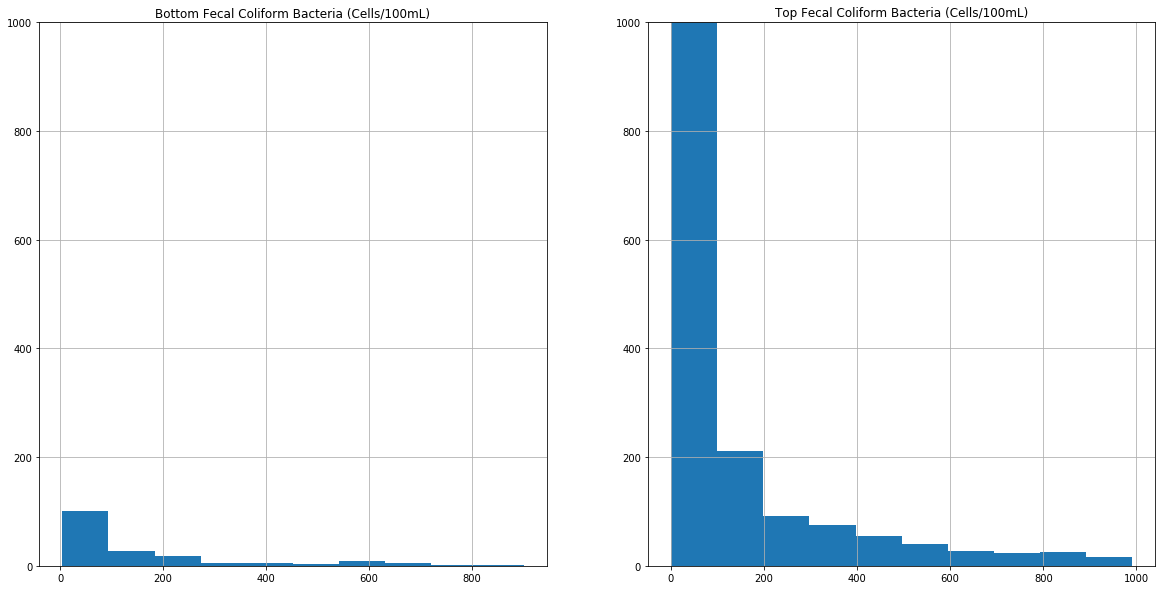

In [99]:
#Looking at fecal counts under 1000 for the year 2016
fig, ax = plt.subplots(1,2,figsize=(20,10))

water_fecal_2016[water_fecal_2016['Bottom Fecal Coliform Bacteria (Cells/100mL)'] <1000]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[0], bins = 10)
water_fecal_2016[water_fecal_2016['Top Fecal Coliform Bacteria (Cells/100mL)'] < 1000]['Top Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[1], bins = 10)

ax[0].set_title('Bottom Fecal Coliform Bacteria (Cells/100mL)')
ax[1].set_title('Top Fecal Coliform Bacteria (Cells/100mL)')
ymin = 0
#setting the max height on the y-axis to a count of 1000
ymax = 1000
ax[0].set_ylim([ymin,ymax])
ax[1].set_ylim([ymin,ymax]);

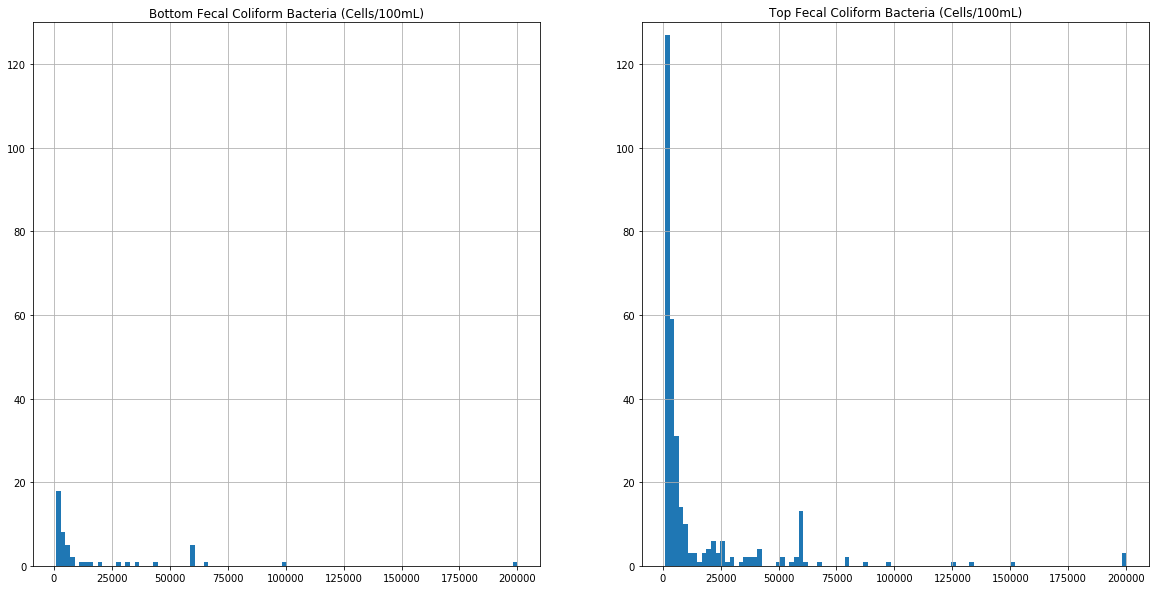

In [100]:
#Looking at fecal counts over 1000 for the year 2016
fig, ax = plt.subplots(1,2,figsize=(20,10))

water_fecal_2016[water_fecal_2016['Bottom Fecal Coliform Bacteria (Cells/100mL)'] >1000]['Bottom Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[0], bins = 100)
water_fecal_2016[water_fecal_2016['Top Fecal Coliform Bacteria (Cells/100mL)'] > 1000]['Top Fecal Coliform Bacteria (Cells/100mL)'].hist(ax = ax[1], bins = 100)

ax[0].set_title('Bottom Fecal Coliform Bacteria (Cells/100mL)')
ax[1].set_title('Top Fecal Coliform Bacteria (Cells/100mL)')
ymin = 0
#setting the max height on the y-axis to a count of 300
ymax = 130
ax[0].set_ylim([ymin,ymax])
ax[1].set_ylim([ymin,ymax]);

In [101]:
## reading in precipitation data from weatherunderground (2007 - 2017)
precip = pd.read_csv('./assets/precip.csv', index_col = 0)

In [102]:
#T represents trace precipitation, replacing it with 0
precip.replace('T','0', inplace = True)

In [103]:
#converting strings to numeric
cols_to_convert = ['day', 'month', 'precip_in', 'precip_m', 'rain',
       'snow', 'snow_in', 'snow_m', 'year']
for cols in cols_to_convert:
    precip[cols] = pd.to_numeric(precip[cols])

In [104]:
precip.columns

Index(['date', 'day', 'month', 'new_col', 'precip_in', 'precip_m', 'rain',
       'snow', 'snow_in', 'snow_m', 'year'],
      dtype='object')

In [105]:
precip['date'] = pd.to_datetime(precip['date']);

In [106]:
precip.dtypes


date         datetime64[ns]
day                   int64
month                 int64
new_col              object
precip_in           float64
precip_m            float64
rain                  int64
snow                  int64
snow_in             float64
snow_m              float64
year                  int64
dtype: object

In [107]:
precip['date'].min()

Timestamp('2002-01-01 17:00:00')

In [108]:
#incorrect precipitation for 12/7/2016. I looked it up on weather underground and it was .07 in (not 70 inches)
precip.loc[precip['date'] == '2016-12-07 17:00:00', 'precip_in'] = .07

In [109]:
#group by to examine total railfall by year, especially 2011, to investigate time-series analysis 
#trend results and the spike in 2011 and 2012
precip.groupby('year').sum()[['precip_in']].to_excel('./assets/rain_totals_by_year.xls')

In [110]:
precip.shape

(5478, 11)

In [111]:
#subsetting precip for 2016 to build data set of distributed flow from each cso over the year.
outflowdays_2016 = precip[precip['year'] ==2016].copy()
outflowdays_2016 = outflowdays_2016.sort_values('precip_in', ascending = False)
outflowdays_2016.shape

(366, 11)

# UP TO HERE

In [112]:
#could make this loop just though each outfall id since they are unique
# Create a weighted list of cso outflow volume. 
# The only cso outfall info available is the yearly number of outfall events and total volume. 
# To build a list of outfalls by day the total volume needs to be spread over the days with rain.
# The rain days are to be chosen by the highest precipitation days in the year. 
# The number of these days is to be equal to the number of events.
# 

#based on the number of days with the highest precipiation equal to the outflow events number for each outfall

# loop through all CSO_events in 2016
for num_events in cso_events['events_16']:
    
    #collect the ids of outfalls with a given number non-zero number of outflow events
    if num_events > 0:
        ids = cso_events.loc[cso_events['events_16']==num_events, 'outfall_id']
        outflow_list=[]
        
        #for each outfall create a weighted list of its volume based 
        #on the highest rain days equal to the number of outflow events
        for id in ids:
            
            #making the weighted list of outflow volume
            outflow_list = outflowdays_2016['precip_in'].sort_values(ascending=False).head(num_events)\
            /outflowdays_2016['precip_in'].sort_values(ascending=False).head(num_events).sum()\
            *cso_events.loc[cso_events['outfall_id'] == id, 'volume_16'].values
            
            
            outflow_list = outflow_list.tolist()
            
            #fill the end of the list with zeroes
            outflow_list.extend([0]*(outflowdays_2016.shape[0]-len(outflow_list)))
            
            #order the dataframe before adding new column
            outflowdays_2016 = outflowdays_2016.sort_values('precip_in', ascending = False)
            
            #outflowdays_2016[id] = pd.Series(outflow_list).sort_values(ascending = False)
            outflowdays_2016[id]= outflow_list


In [113]:
outflowdays_2016.sort_values('precip_in', ascending = False).head()


date  day  month     new_col  precip_in  precip_m  rain  \
22  2016-01-23 17:00:00   23      1  2016-01-23       2.31     58.67     0   
330 2016-11-29 17:00:00   29     11  2016-11-29       2.20     55.88     1   
316 2016-11-15 17:00:00   15     11  2016-11-15       1.81     45.97     1   
9   2016-01-10 17:00:00   10      1  2016-01-10       1.80     45.72     1   
150 2016-05-30 16:00:00   30      5  2016-05-30       1.65     41.91     1   

     snow  snow_in  snow_m    ...       WI-073    TI-003     TI-011    TI-022  \
22      1     26.6   67.56    ...     0.326733  3.743335  15.384282  3.785930   
330     0      0.0    0.00    ...     0.311174  3.565081  14.651697  3.605648   
316     0      0.0    0.00    ...     0.256011  2.933089  12.054351  2.966465   
9       0      0.0    0.00    ...     0.254597  2.916884  11.987752  2.950076   
150     0      0.0    0.00    ...     0.233380  2.673811  10.988773  2.704236   

       WI-053    WI-015    WI-017    WI-036    WI-075    WI-077  
22   2.562784  0.720749  0.792824  0.216225  8.576911  4.901092  
330  2.440746  0.686427  0.755070  0.205928  8.168487  4.667707  
316  2.008069  0.564743  0.621217  0.169423  6.720437  3.840250  
9    1.996974  0.561622  0.617785  0.168487  6.683307  3.819033  
150  1.830560  0.514821  0.566303  0.154446  6.126365  3.500780  

[5 rows x 368 columns]

In [114]:
#finding top10 csos with the highest mean fecal coliform results
water_fecal.groupby('Sampling Location').mean().sort_values('Top Fecal Coliform Bacteria (Cells/100mL)', ascending = False)\
.head(10).index

Index(['BB3', 'CIC2', 'BB2', 'HP-004', 'AC1', 'GC4', 'BR4', 'GC5', 'GC6',
       'NC0'],
      dtype='object', name='Sampling Location')

In [115]:
#subsetting top 10 sites to look at the spread of data for each one
top10_sites = water_fecal[water_fecal['Sampling Location'].isin(['BB3', 'CIC2', 'BB2', 'HP-004', 'AC1', 'GC4', 'BR4', 'GC5', 'GC6',
       'NC0'])] 


/Users/ann/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


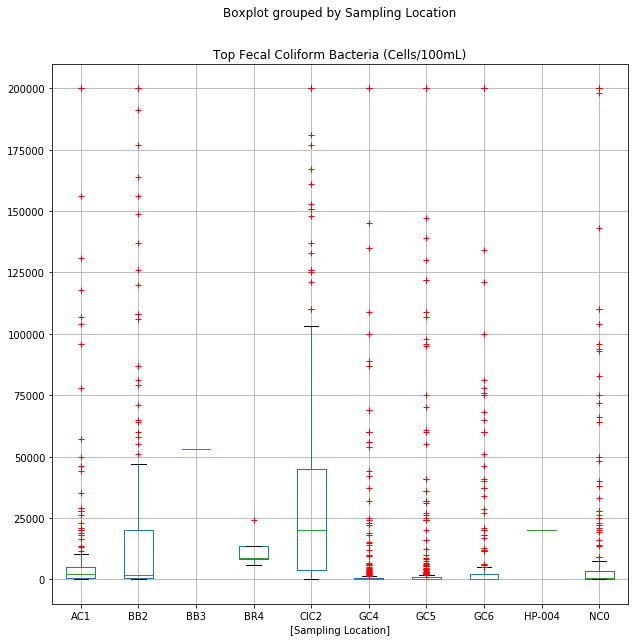

In [116]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
top10_sites[['Sampling Location','Top Fecal Coliform Bacteria (Cells/100mL)']].boxplot(by = 'Sampling Location',sym='r+',ax = ax)

In [117]:
fecal_means_subset = water_fecal[water_fecal['Sample Date'].dt.year < 2017].groupby('Sample Date').mean().reset_index()\
[['Sample Date', 'Top Sample Temperature (ºC)','Top Fecal Coliform Bacteria (Cells/100mL)']].copy()

In [118]:
precip_only = precip[['date','precip_in']].sort_values('date').copy()

In [119]:
precip_only['sum_precip'] = precip_only['precip_in'].rolling(window = 2, center = False).sum()

In [120]:
precip_only['date'] = precip_only['date'].dt.date

In [121]:
precip_only.head()

date  precip_in  sum_precip
0  2002-01-01        0.0         NaN
1  2002-01-02        0.0         0.0
2  2002-01-03        0.0         0.0
3  2002-01-04        0.0         0.0
4  2002-01-05        0.0         0.0

In [122]:
#metric_df = forecast.set_index('ds')[['yhat']].join(water_fecal_ts_test.set_index('ds').y).reset_index()
fecal_means = fecal_means_subset.set_index('Sample Date').join(precip_only.set_index('date')['sum_precip']).reset_index()

In [123]:
fecal_means['Sample Date'] = fecal_means['Sample Date'].dt.date

In [124]:

#need water summed by previous week. look at time series intro

fecal_means.dropna(inplace = True)

In [125]:
fecal_means.tail()

Sample Date  Top Sample Temperature (ºC)  \
2158  2016-11-02                    13.728696   
2160  2016-11-09                    13.577500   
2165  2016-12-12                     7.634000   
2166  2016-12-13                     7.828824   
2167  2016-12-14                     6.461818   

      Top Fecal Coliform Bacteria (Cells/100mL)    sum_precip  
2158                                  77.260870 -6.439294e-15  
2160                                 118.350000  6.000000e-02  
2165                                 943.750000  5.300000e-01  
2166                                 808.647059  5.000000e-01  
2167                                  69.318182 -6.328271e-15

In [126]:
# precip_only = precip[['date','precip_in']].copy()

#not sure if either of the below is needed
# precip_only['date']= pd.to_datetime(precip_only['date'])
# #precip_only.set_index('date', inplace = True)


# precip_only.set_index(pd.DatetimeIndex(precip_only['date']), inplace = True)
# precip_only.index
# precip_only['precip_in'].resample('W').sum();

In [127]:
fecal_means.corr()

Top Sample Temperature (ºC)  \
Top Sample Temperature (ºC)                                   1.000000   
Top Fecal Coliform Bacteria (Cells/100mL)                     0.035810   
sum_precip                                                    0.046786   

                                           Top Fecal Coliform Bacteria (Cells/100mL)  \
Top Sample Temperature (ºC)                                                 0.035810   
Top Fecal Coliform Bacteria (Cells/100mL)                                   1.000000   
sum_precip                                                                  0.189495   

                                           sum_precip  
Top Sample Temperature (ºC)                  0.046786  
Top Fecal Coliform Bacteria (Cells/100mL)    0.189495  
sum_precip                                   1.000000

In [128]:
import seaborn as sns

In [129]:
from sklearn.linear_model import LinearRegression

In [130]:
lr = LinearRegression()
X= fecal_means[['Top Sample Temperature (ºC)', 'sum_precip']]
#X= fecal_means[['Top Sample Temperature (ºC)']]
y = np.log(fecal_means[['Top Fecal Coliform Bacteria (Cells/100mL)']])

In [131]:
X.head()

Top Sample Temperature (ºC)  sum_precip
692                    12.933333        0.00
693                    14.833333        0.00
694                    14.166667        1.05
695                    14.650000        0.05
699                    17.333333        0.00

Text(0,0.5,'Log(Fecal Coliform Count)')

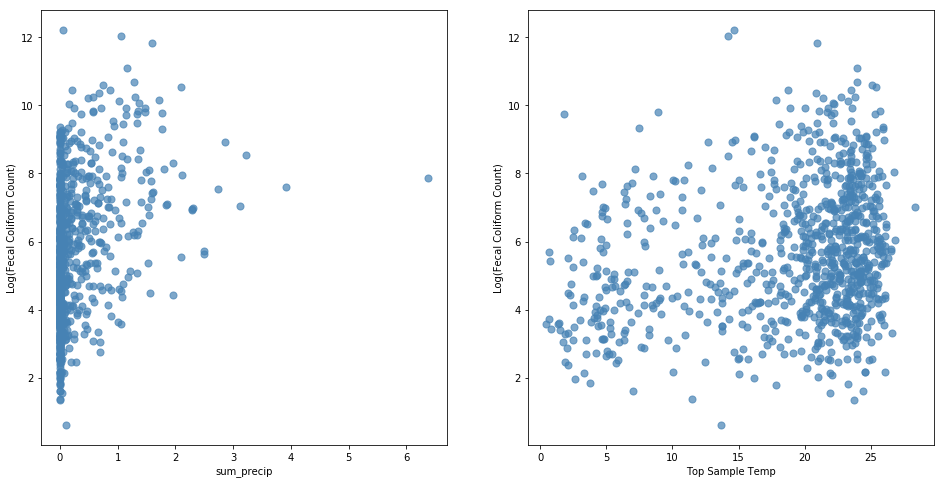

In [132]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].scatter(X['sum_precip'], y, s = 50, c= 'steelblue', alpha = 0.7)
ax[1].scatter(X['Top Sample Temperature (ºC)'], y, s = 50, c= 'steelblue', alpha = 0.7)
ax[1].set_xlabel('Top Sample Temp')
ax[1].set_ylabel('Log(Fecal Coliform Count)')
ax[0].set_xlabel('sum_precip')
ax[0].set_ylabel('Log(Fecal Coliform Count)')

Text(0.5,1,'Distribution of Fecal Coliform Count')

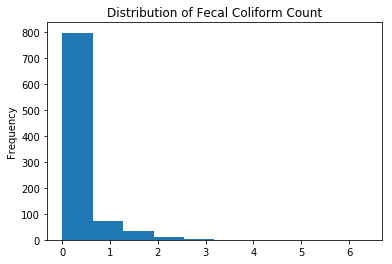

In [133]:
X['sum_precip'].plot(kind = 'hist').set_title('Distribution of Fecal Coliform Count')


Text(0.5,1,'Distribution of Water Temperature (Celcius)')

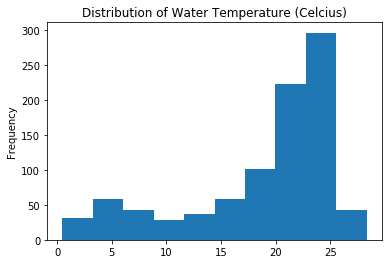

In [134]:
X['Top Sample Temperature (ºC)'].plot(kind = 'hist').set_title('Distribution of Water Temperature (Celcius)')


In [135]:
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [136]:
print(lr.coef_)
print(lr.intercept_)

[[0.06082975 1.29997329]]
[4.18969721]


In [137]:
lr.score(X,y)

0.16785190671354244

Text(0.5,1,'Distribution of Residuals')

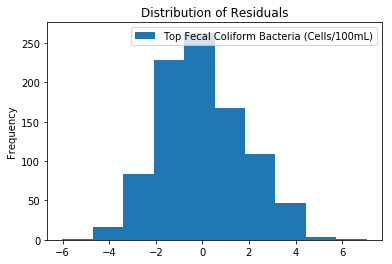

In [138]:
yhat = lr.predict(X)
residuals = y - yhat
residuals.plot(kind = 'hist').set_title('Distribution of Residuals')

Text(0,0.5,'residuals')

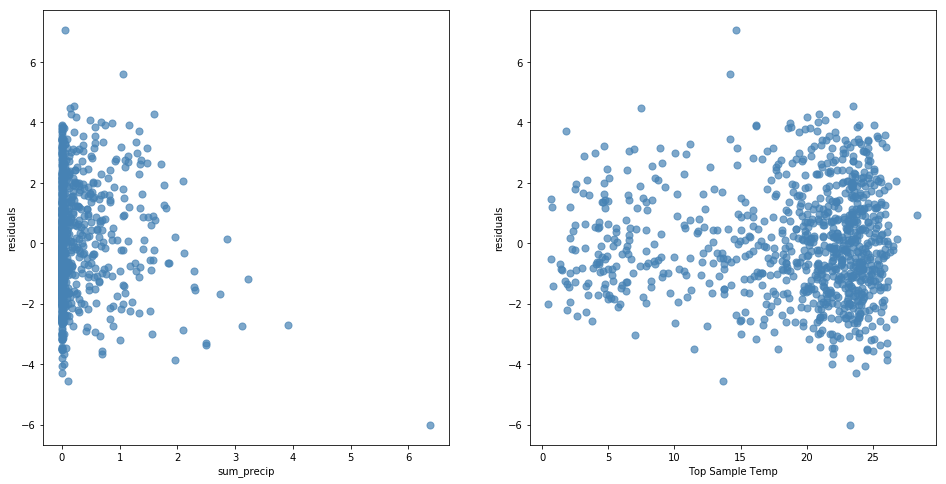

In [139]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].scatter(X['sum_precip'], residuals, s = 50, c= 'steelblue', alpha = 0.7)
ax[1].scatter(X['Top Sample Temperature (ºC)'], residuals, s = 50, c= 'steelblue', alpha = 0.7)
ax[1].set_xlabel('Top Sample Temp')
ax[1].set_ylabel('residuals')
ax[0].set_xlabel('sum_precip')
ax[0].set_ylabel('residuals')

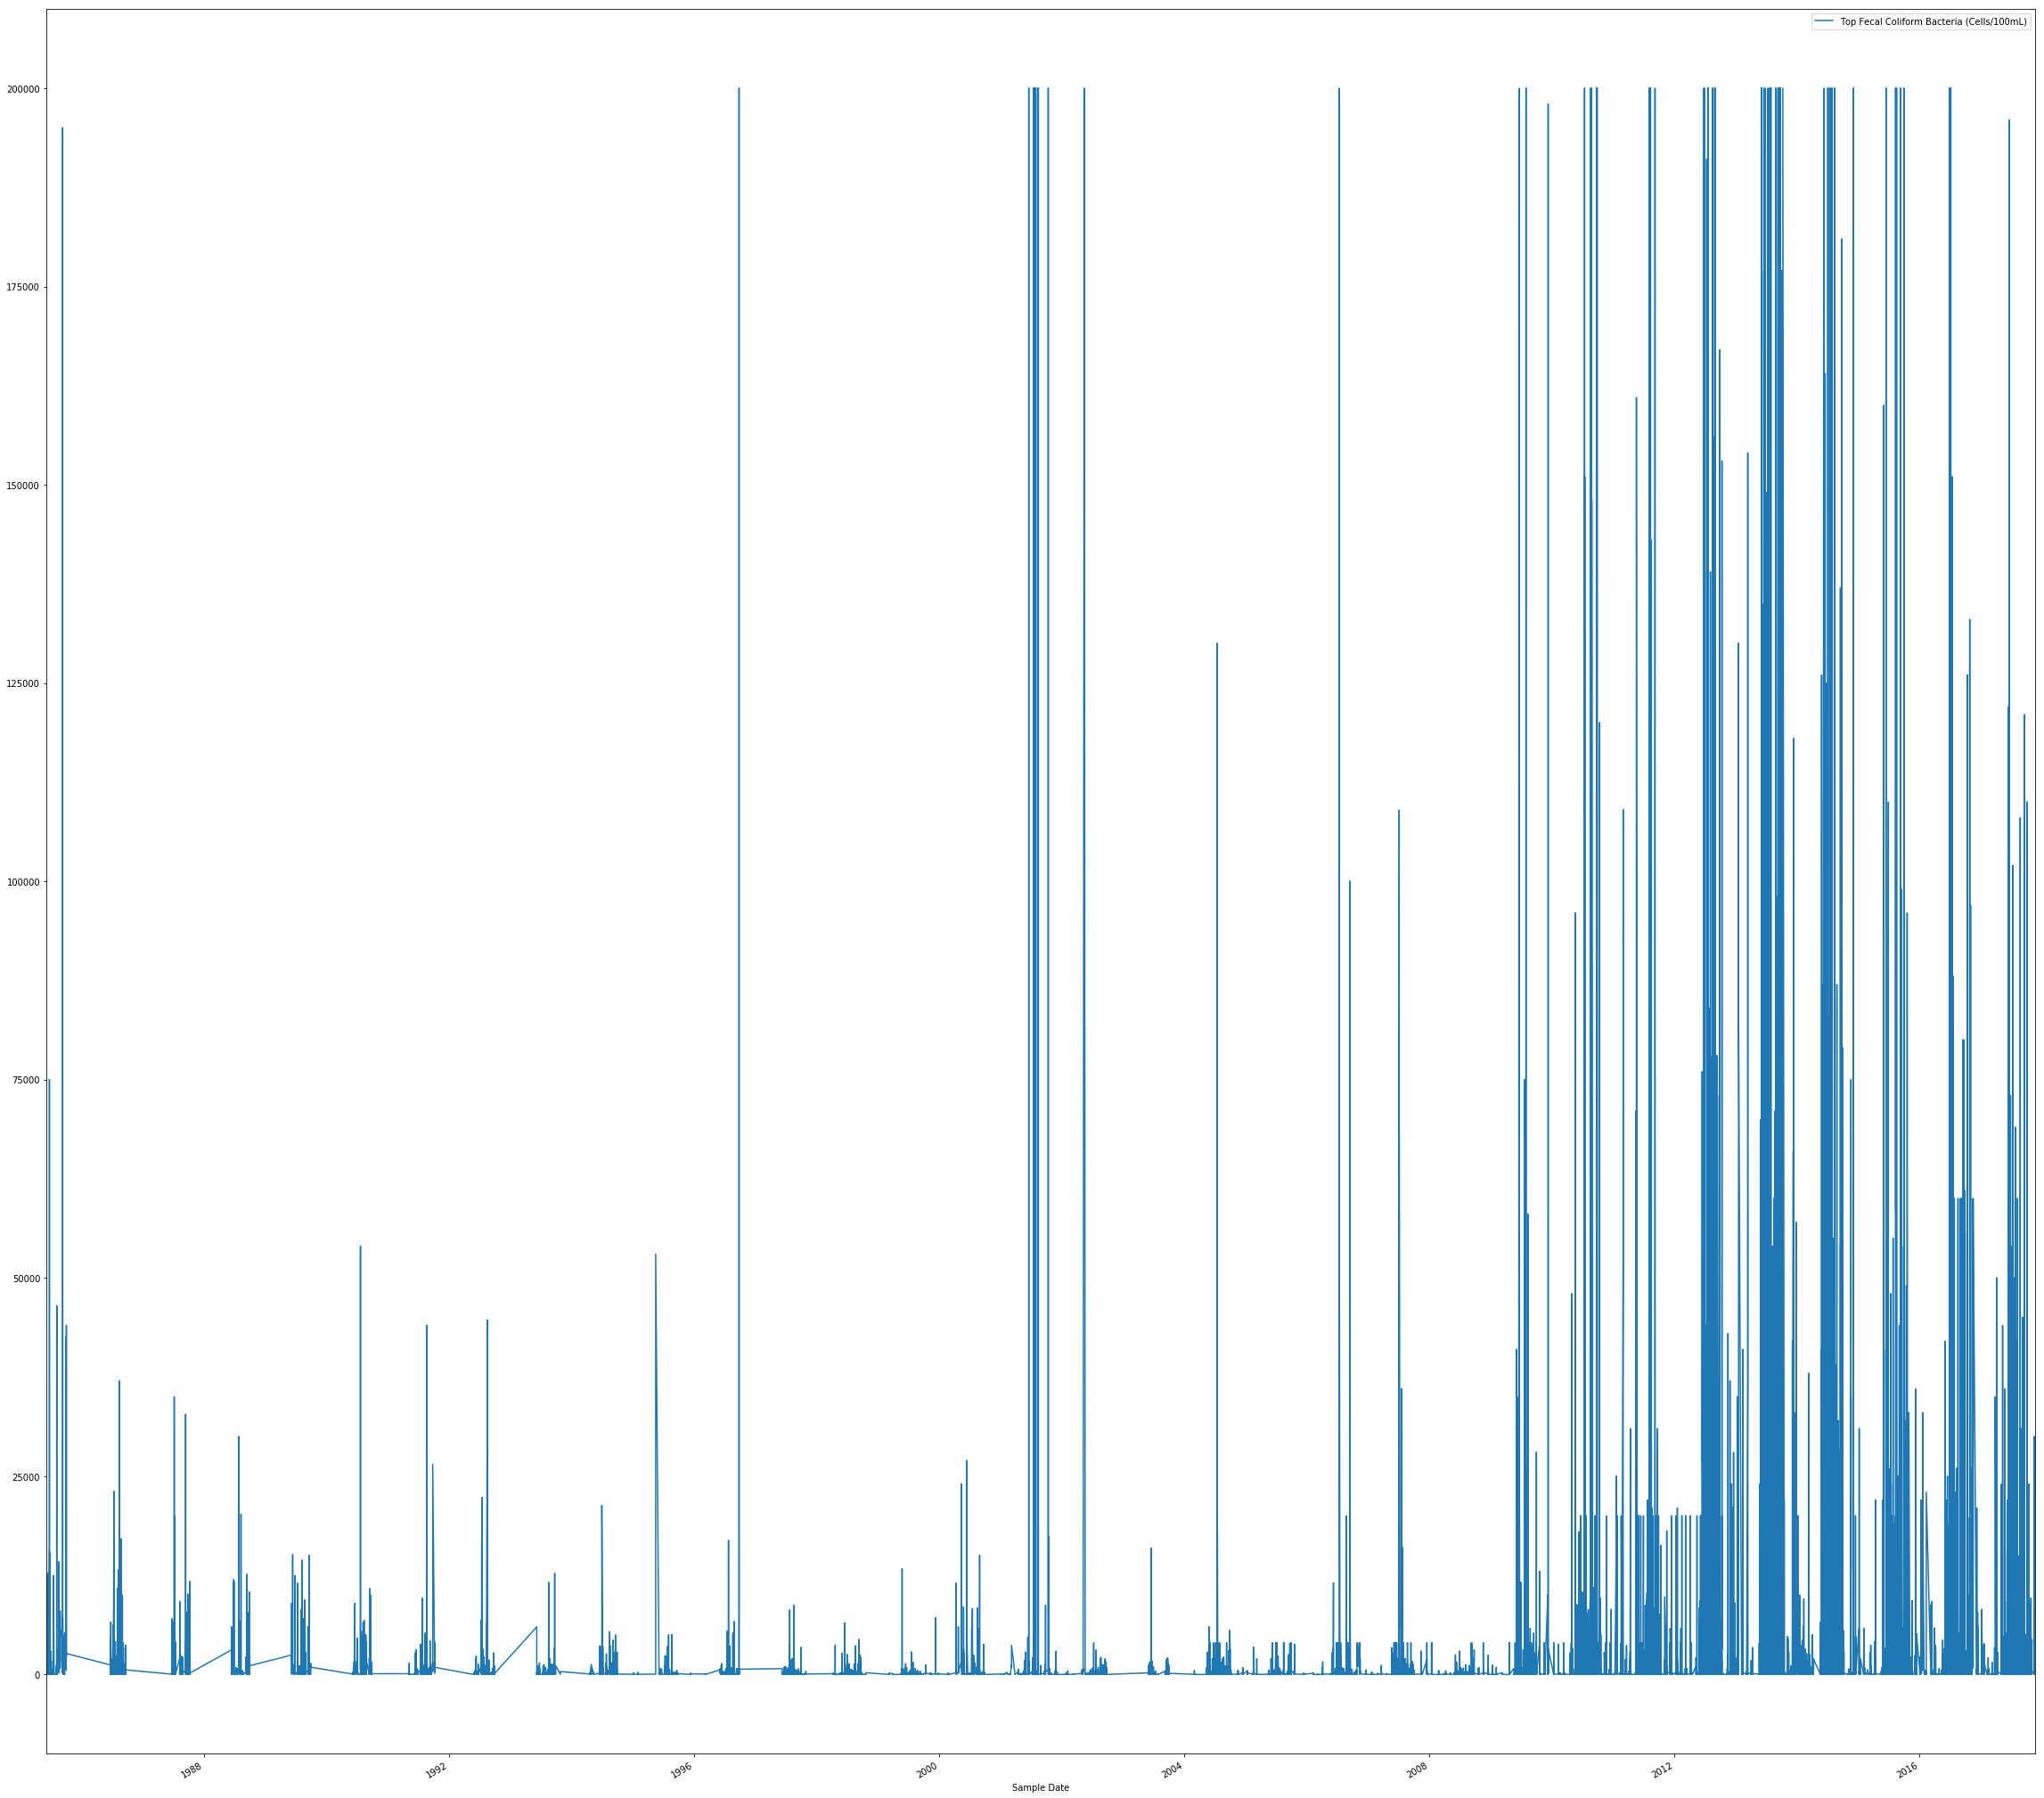

In [140]:
#line plot of all fecal coliform results by date
fig, ax = plt.subplots(1,1,figsize=(40,40))
water_fecal[['Sample Date','Top Fecal Coliform Bacteria (Cells/100mL)']].plot(x = 'Sample Date', y = 'Top Fecal Coliform Bacteria (Cells/100mL)',ax = ax)

In [141]:
#aligning the projection for the shape files
# i think this is screwed up because i overwrote cso_drainage after i read it in way above.
cso_events = cso_events.to_crs(cso_drainage.crs)
sewersheds = sewersheds.to_crs(cso_drainage.crs)
interceptors = interceptors.to_crs(cso_drainage.crs)


In [142]:
fecal_means['Sample Date'] = pd.to_datetime(fecal_means['Sample Date'])

In [143]:
#fecal coliform subset for time series analysis with Facebook Prophet
water_fecal_ts = fecal_means[['Sample Date', 'Top Fecal Coliform Bacteria (Cells/100mL)']].copy()

In [144]:
water_fecal_ts.columns = ['ds','y']

In [145]:
water_fecal_ts.head()

ds              y
692 2002-05-06      75.000000
693 2002-05-08     424.333333
694 2002-05-13  166000.000000
695 2002-05-15  200000.000000
699 2002-05-30      24.000000

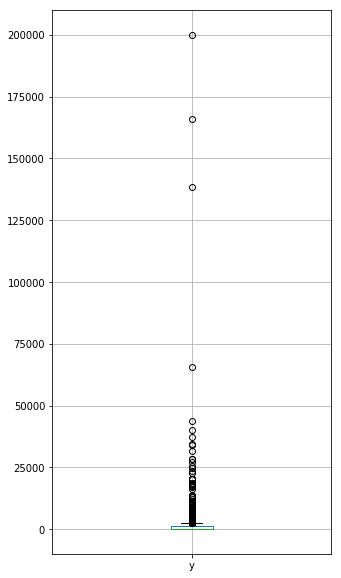

In [146]:
fix, ax = plt.subplots(1,1,figsize = (5, 10))
water_fecal_ts.boxplot(ax = ax)

In [147]:
#setting min fecal count to 1 instead of zero so values can be transformed by the logarithm
water_fecal_ts.loc[water_fecal_ts['y'] == 0,'y'] = 1.0

In [148]:
#taking log of the values
water_fecal_ts['y'] = np.log(water_fecal_ts['y'])

In [149]:
water_fecal_ts['ds'].max()

Timestamp('2016-12-14 00:00:00')

In [150]:
water_fecal_ts_train = water_fecal_ts[water_fecal_ts['ds'] <= '2016-11-20'].copy()

In [151]:
water_fecal_ts_test =  water_fecal_ts[water_fecal_ts['ds'] > '2016-11-20'].copy()

In [152]:
water_fecal_ts_train.shape

(916, 2)

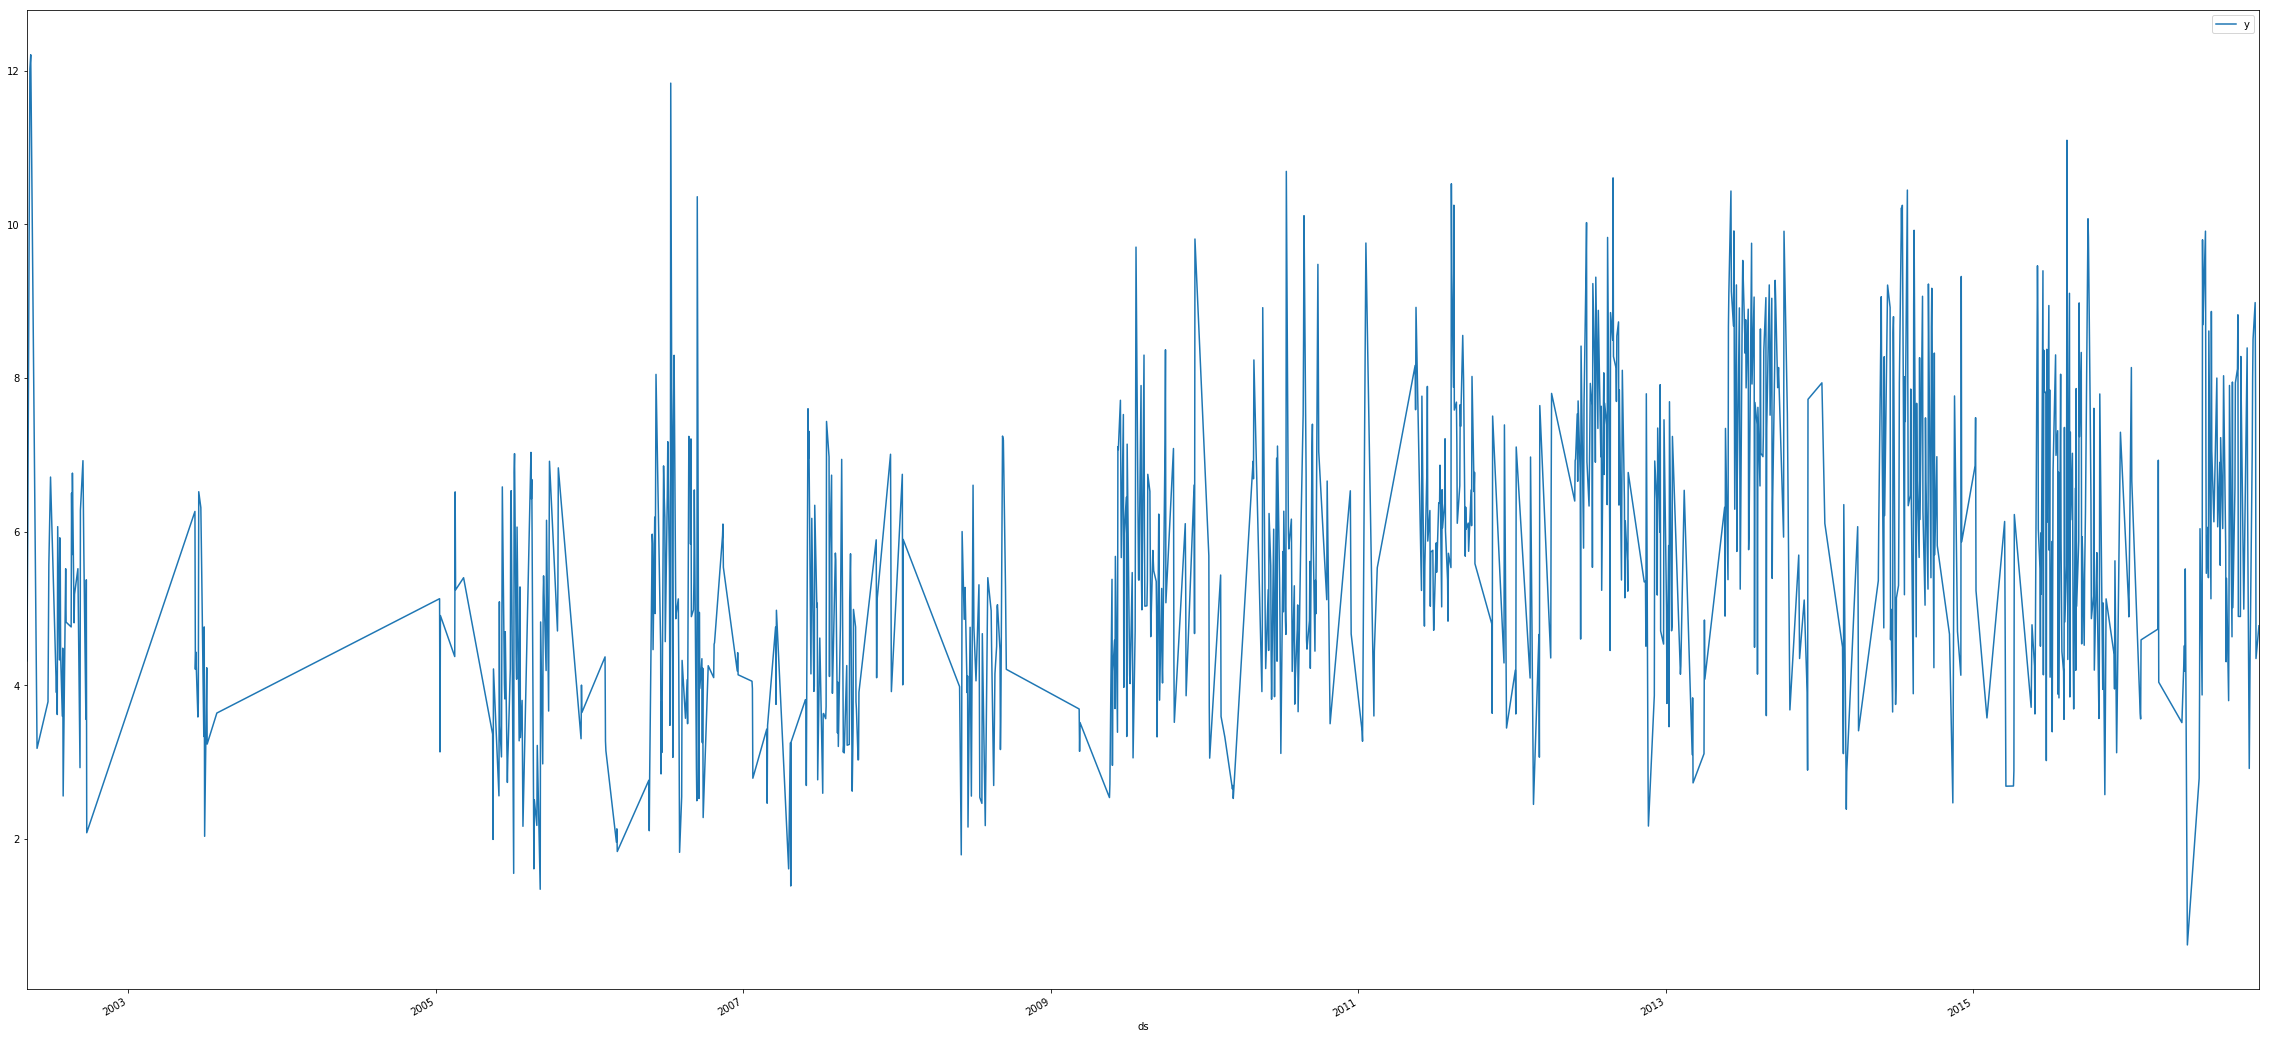

In [153]:
fig, ax = plt.subplots(1,1,figsize=(40,20))
water_fecal_ts_train.plot(x = 'ds', y = 'y',ax = ax)



In [154]:
model = Prophet()
model.fit(water_fecal_ts_train)

/Users/ann/anaconda3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [155]:
future = model.make_future_dataframe(periods = 365)

In [156]:
forecast = model.predict(future)

In [157]:
forecast.tail()

ds         t     trend  seasonal_lower  seasonal_upper  \
1276 2017-11-05  1.068100  5.708632        0.097776        0.097776   
1277 2017-11-06  1.068289  5.708170       -0.358970       -0.358970   
1278 2017-11-07  1.068478  5.707708       -0.561886       -0.561886   
1279 2017-11-08  1.068666  5.707246       -0.072530       -0.072530   
1280 2017-11-09  1.068855  5.706784       -0.673755       -0.673755   

      trend_lower  trend_upper  yhat_lower  yhat_upper    weekly  \
1276     5.668394     5.746901    3.832274    7.892831  0.052221   
1277     5.667747     5.746544    3.152221    7.528465 -0.327079   
1278     5.667101     5.746185    2.949431    7.135937 -0.448740   
1279     5.666480     5.745826    3.425881    7.684111  0.123941   
1280     5.665860     5.745467    2.992117    7.052707 -0.393707   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
1276      0.052221      0.052221  0.045555      0.045555      0.045555   
1277     -0.327079     -0.327079 -0.031891     -0.031891     -0.031891   
1278     -0.448740     -0.448740 -0.113146     -0.113146     -0.113146   
1279      0.123941      0.123941 -0.196471     -0.196471     -0.196471   
1280     -0.393707     -0.393707 -0.280048     -0.280048     -0.280048   

      seasonal      yhat  
1276  0.097776  5.806408  
1277 -0.358970  5.349199  
1278 -0.561886  5.145822  
1279 -0.072530  5.634716  
1280 -0.673755  5.033029

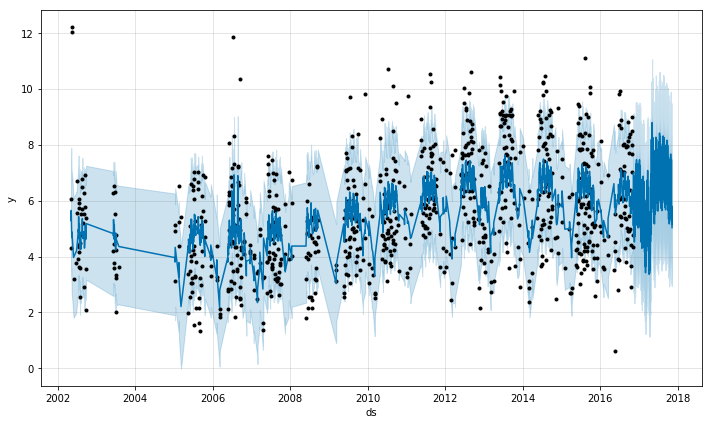

In [158]:
model.plot(forecast);

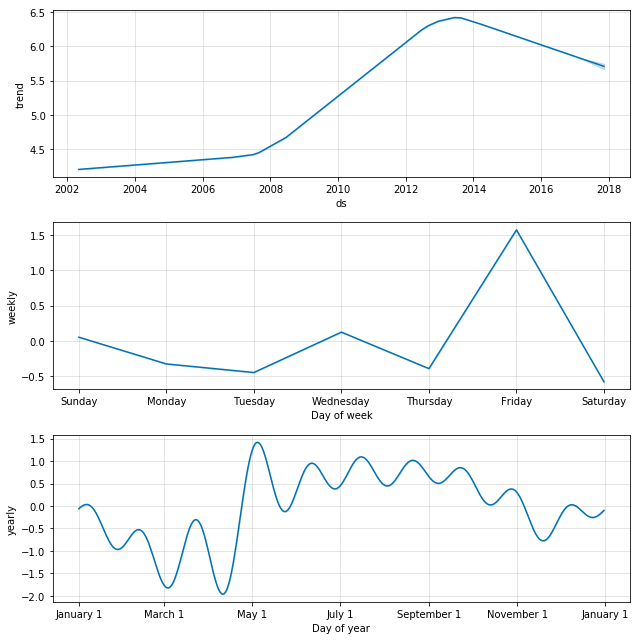

In [159]:
model.plot_components(forecast);

In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [161]:
metric_df = forecast.set_index('ds')[['yhat']].join(water_fecal_ts_test.set_index('ds').y).reset_index()

In [162]:
metric_df.shape

(1281, 3)

In [163]:
metric_df.dropna(inplace=True)

In [164]:
metric_df['yhat'] = np.exp(metric_df['yhat'])
metric_df['y'] = np.exp(metric_df['y'])

In [165]:
mean_squared_error(metric_df.y, metric_df.yhat)

308616.9802927236

In [166]:
mean_absolute_error(metric_df.y, metric_df.yhat)

529.8458162698349

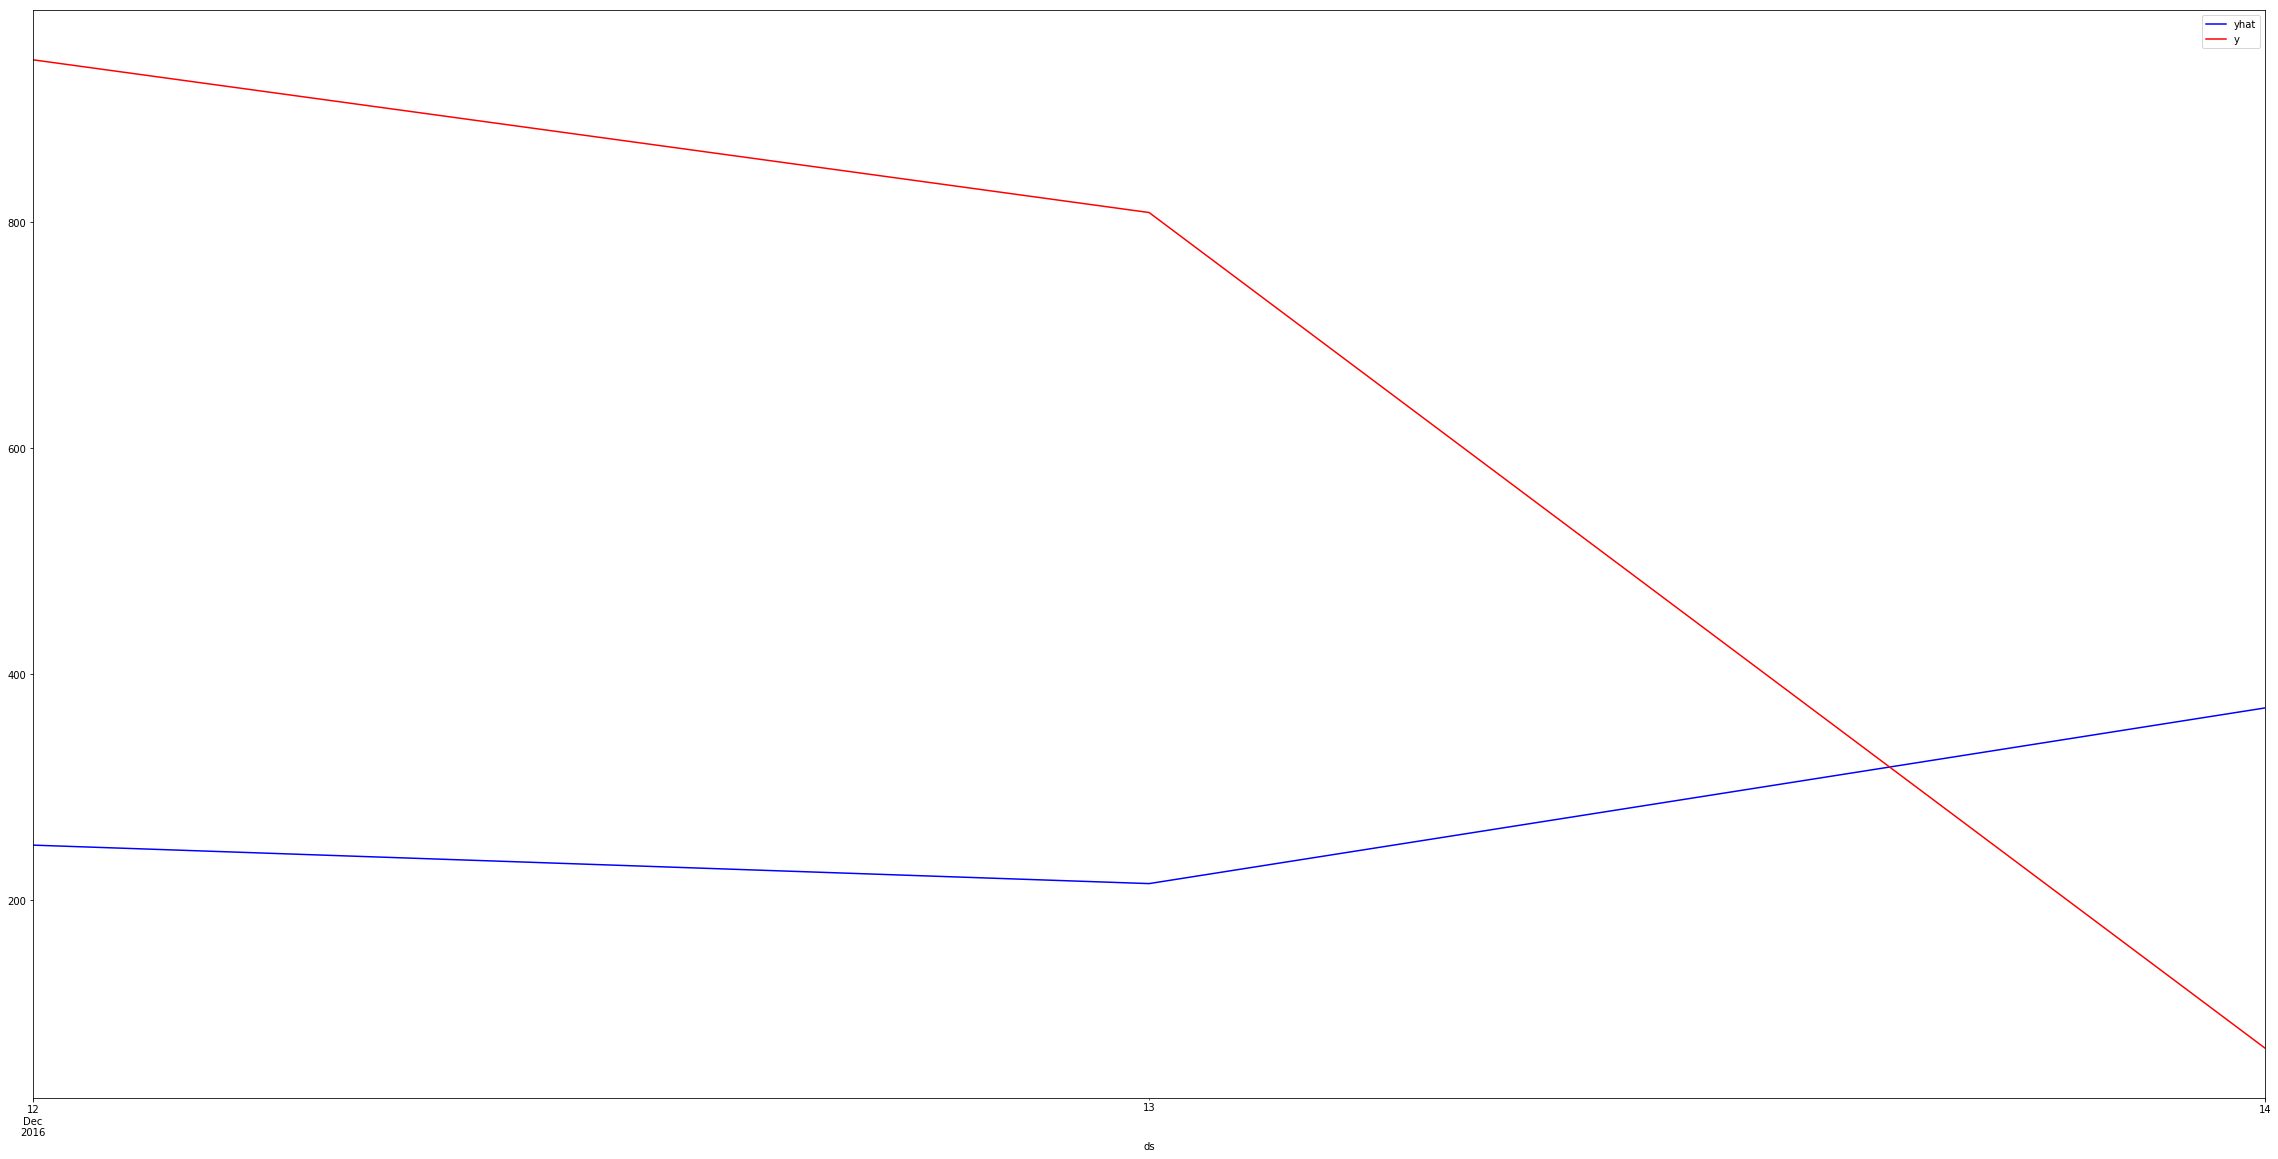

In [167]:
fig, ax = plt.subplots(1,1,figsize=(40,20))

metric_df.plot(x = 'ds', y = 'yhat',c = 'blue',ax = ax)
metric_df.plot(x = 'ds', y = 'y',c = 'red',ax = ax)

#ax.set_ylim(0,150)


The only dataset not yet read in is 'DEC CSO outfalls in NYS'. It is a file named 'Combined_Sewer_Overflows__CSOs__Map.csv'. I think it is another recored of all CSO overflows in the state.